# <font color='skyblue'>**Prueba Técnica Científico de Datos**</font>
 
## Juan Camilo Florez Caro

El siguiente notebook tiene como objetivo resolver tanto el caso de negocio como los ejercicios aplicados referenciados dentro de la prueba realizada por Colsubsidio


# **PARTE 1 (75%)**

Para resolver las preguntas se seguirá la metodología CRISP-DM, la cual es una de multiples alternativas para llegar a buen término con el desarrollo, despliegue y posterior uso de los modelos de ciencia de datos.

Esta metodología esta compuesta por los siguientes pasos:

- a) Entendimiento del negocio
- b) Entendimiento y preparación de los datos
- c) Construcción del modelo(s)
- d) Evaluación del modelo(s)
- e) Despliegue


### <font color='orange'>**a) Entendimiento del negocio**</font>



Como puntos de partida tenemos dos necesidades puntuales por parte de la compañia

1) **Construir un score que nos resuma la probabilidad de que un cliente que ha tenido un cupo de crédito nos cancele su producto (modelo supervisado).** Dentro del ejercicio no es explicito el uso que se le daría a esta calificación por parte de la UES de crédito pero para efectos prácticos definiremos que este score sería utilizado en campañas de retención, donde a los clientes con mayores probabilidades de cancelar su cupo de crédito se le aplicará mediante telemercadeo y envíos de correos electrónico campañas preventivas de up-selling/cross-selling que permitan fidelizar a los clientes antes de que manifiesten la intención de cancelar su producto

2) **Segmentar y perfilar a los clientes que han tenido crédito (modelo no supervisado)** donde el objetivo es diseñar ofertas diferenciadas de mercadeo para ofrecerles nuevos cupos de crédito o seguros (upselling).


* _Nota:_ En este ejercicio de segmentación partiremos de los clientes que ya tienen crédito por lo cual las conculsiones hablarán de esta población. Sería interesante en ejercicios segmentar y caracterizar a aquellos clientes que nunca han tenido crédito para luego conocer que los diferencia de quienes si lo han tenido, dandole una connotación de un ejercicio de clasificación y habilitando de esta manera el posible diseño de una estrategia enfocada en ofrecerles su primer cupo de crédito la cual se podria valer de un score que resuma la probabilidad de que un cliente nos diga que SI a la oferta de este cupo

### <font color='orange'>**b) Entendimiento y procesamiento de los datos**</font>

Como punto de partida tendremos 3 bases de datos las cuales contienen información cliente por cliente (supuesto: cada cliente puede tener máximo 1 cupo), esta información es de indole comportamental (sobre el uso que ha dado a su cupo de crédito y subsidios) y de índole sociodemográfica. La información inicialmente se encuentra dispersa en archivos diferentes por lo cual debemos consolidarla y limpiarla (duplicados, missingvalues, datatypes).

Adicionalmente tendrémos una base de test la cual utilizaremos en la etapa de despliegue de los modelos construidos

* Importamos los archivos

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels as stats

In [2]:
df_train = pd.read_csv('train.csv', sep=';', encoding = "ISO-8859-1")
df_demograficas = pd.read_excel('train_test_demograficas.xlsx')
df_subsidios = pd.read_excel('train_test_subsidios.xlsx')
#-------------------------------------

df_test = pd.read_csv('test.csv', sep=';', encoding = "ISO-8859-1")


* Corroboramos si se tienen duplicados

In [3]:
#Largo de los dataset
print(len(df_train), len(df_test),len(df_demograficas),len(df_subsidios)) 

50001 5001 55002 55002


In [4]:
# Conteo unico de los Id
print(len(df_train.id.unique()), len (df_test.id.unique()), len (df_demograficas.id.unique()), len (df_subsidios.id.unique()))

50001 5001 55002 55002


conclusión: No se tienen duplicados en ninguno de los dataset

* Missing values

In [5]:
print('df_train \n\n',df_train.isna().sum(),'\n\n df_test \n\n',df_test.isna().sum(),'\n\n df_demograficas \n\n',df_demograficas.isna().sum(),'\n\n df_subsidios \n\n',df_subsidios.isna().sum())

df_train 

 id                        0
Fecha.Expedicion          0
Cancelacion           48589
Gestionable           48589
Retencion             48589
TIPO                  48589
ANO_MES               48589
Target                    0
Fecha.Proceso             0
Disponible.Avances        0
Limite.Avances            0
Total.Intereses           0
Saldos.Mes.Ant            0
Pagos.Mes.Ant             0
Vtas.Mes.Ant              0
Edad.Mora                 0
Limite.Cupo               0
Pago.del.Mes              0
Pago.Minimo               0
Vr.Mora                   0
Vr.Cuota.Manejo           0
Saldo                     0
dtype: int64 

 df_test 

 id                       0
Fecha.Expedicion         0
Cancelacion           4864
Gestionable           4864
TIPO                  4864
ANO_MES               4864
Fecha.Proceso            0
Disponible.Avances       0
Limite.Avances           0
Total.Intereses          0
Saldos.Mes.Ant           0
Pagos.Mes.Ant            0
Vtas.Mes.Ant         

<Axes: >

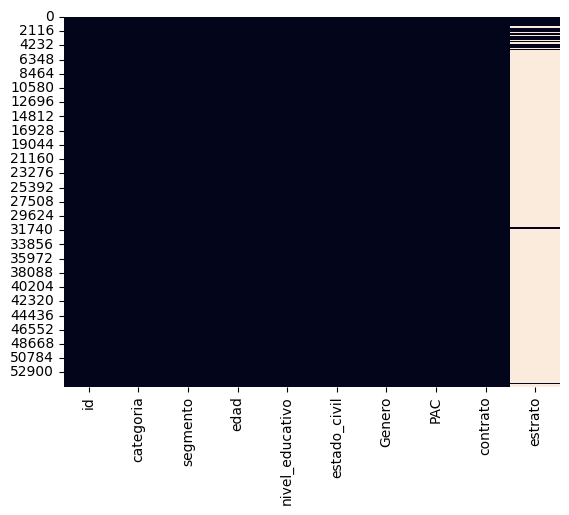

In [6]:
#Grafico de missing values: Alerta en variable estrato
sns.heatmap(df_demograficas.isnull(), cbar=False)

Conclusiones: Contamos con pocos missing values, la mayoria de estos se presentan en los dataset de train y test, en aquellas variables que se tienen unicamente para aquellos clientes que ya han cancelado su producto.

Una alerta que tenemos es en la variable ESTRATO que se encuentra en el dataset de df_demográficas donde de 55.002, 50.584 no tienen esta información (91% de las observaciones), de momento la mantendremos, esperando a verificar si es necesaria o podriamos prescindir de ella, en caso de ser necesaria podriamos pensar en alguna metodología de imputación si lo deseamos

* Data types

In [7]:
pd.set_option('display.max_columns', 500)
df_subsidios

,id,cuota_monetaria,sub_vivenda,bono_lonchera
0,1,0,0,0
1,2,0,0,0
2,3,1,0,1
3,4,0,0,0
4,5,0,0,0
...,...,...,...,...
54997,54998,1,0,1
54998,54999,1,0,1
54999,55000,1,0,1
55000,55001,1,0,1


In [8]:
# Clasificamos las variables segpun su tipo Train y Test

fechas = ['Fecha.Expedicion','Fecha.Proceso'] #ANO_MES tendrá una transformación particular
categoricas = ['id','Cancelacion','Gestionable','Retencion','TIPO','Target']
metricas = ['Disponible.Avances','Limite.Avances','Total.Intereses','Saldos.Mes.Ant','Pagos.Mes.Ant','Vtas.Mes.Ant','Edad.Mora','Limite.Cupo','Pago.del.Mes','Pago.Minimo','Vr.Mora','Vr.Cuota.Manejo','Saldo']

fechas_test = ['Fecha.Expedicion','Fecha.Proceso'] #ANO_MES tendrá una transformación particular
categoricas_test = ['id','Cancelacion','Gestionable','TIPO']
metricas_test = ['Disponible.Avances','Limite.Avances','Total.Intereses','Saldos.Mes.Ant','Pagos.Mes.Ant','Vtas.Mes.Ant','Edad.Mora','Limite.Cupo','Pago.del.Mes','Pago.Minimo','Vr.Mora','Vr.Cuota.Manejo','Saldo']


# Clasificamos las variables segpun su tipo df_demograficas

categoricas_demo = ['id','categoria','segmento','nivel_educativo','estado_civil','Genero','PAC','contrato','estrato']
metricas_demo = ['edad']

# Clasificamos las variables segpun su tipo df_subsidios

categoricas_subs = ['id','cuota_monetaria', 'sub_vivenda','bono_lonchera']

In [9]:
#Ajustamos las variables en train
df_train['ANO_MES']= pd.to_datetime(df_train['ANO_MES'].astype('str'),format= '%Y%m.0')
df_test['ANO_MES']= pd.to_datetime(df_test['ANO_MES'].astype('str'),format= '%Y%m.0')


In [10]:
#Ajustes en Train

for i in fechas:
    df_train[i] = pd.to_datetime(df_train[i],errors = 'coerce', format='%d/%m/%Y')

for i in categoricas:
    df_train[i] = np.where(df_train[i].isnull(),df_train[i],df_train[i].astype('str'))

for i in metricas:
    df_train[i] = pd.to_numeric(df_train[i].astype('str').str.replace(' ',''), errors = 'coerce', downcast = 'float')



In [11]:

# Ajustes en Test

for i in fechas_test:
    df_test[i] = pd.to_datetime(df_test[i],errors = 'coerce', format='%d/%m/%Y')

for i in categoricas_test:
    df_test[i] = np.where(df_test[i].isnull(),df_test[i],df_test[i].astype('str'))

for i in metricas_test:
    df_test[i] = pd.to_numeric(df_test[i].astype('str').str.replace(' ',''), errors = 'coerce', downcast = 'float')


In [12]:
# Ajustes en demograficas

for i in categoricas_demo:
    df_demograficas[i] = np.where(df_demograficas[i].isnull(),df_demograficas[i],df_demograficas[i].astype('str'))

for i in metricas_demo:
    df_demograficas[i] = pd.to_numeric(df_demograficas[i].astype('str').str.replace(' ',''), errors = 'coerce', downcast = 'float')

In [13]:
# Ajustes en subsidios

for i in categoricas_subs:
    df_subsidios[i] = np.where(df_subsidios[i].isnull(),df_subsidios[i],df_subsidios[i].astype('str'))

* Consolidación

Teniendo en cuenta que tenemos información dispersa en multiples archivos y entendiendo que la relación es de 1:1 por medio del campo ID, procederemos a integrarlas, y quedar de esta forma con dos bases, una de train y una de test que consolide la información comportamental, de los subsidios y demografica

In [14]:
df_train_consolidado = df_train.merge(df_demograficas,how='left', on='id').merge(df_subsidios,how='left', on='id')
df_train_consolidado

,id,Fecha.Expedicion,Cancelacion,Gestionable,Retencion,TIPO,ANO_MES,Target,Fecha.Proceso,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,Pago.Minimo,Vr.Mora,Vr.Cuota.Manejo,Saldo,categoria,segmento,edad,nivel_educativo,estado_civil,Genero,PAC,contrato,estrato,cuota_monetaria,sub_vivenda,bono_lonchera
0,1,2006-11-04,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,1050000.0,1050000.0,0.0,0.0,0.0,0.0,0.0,2625000.0,0.0,0.0,0.0,0.0,0.0,B,Segmento_Medio,31.0,tecnico_tecnologico,soltero,F,1,4,NaN,0,0,0
1,2,2007-08-17,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,1180000.0,1180000.0,0.0,0.0,0.0,0.0,0.0,2950000.0,0.0,0.0,0.0,0.0,0.0,C,Segmento_Medio,38.0,tecnico_tecnologico,soltero,M,1,1,NaN,0,0,0
2,3,2008-05-08,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,150000.0,150000.0,0.0,0.0,0.0,0.0,0.0,500000.0,0.0,0.0,0.0,0.0,0.0,A,Segemnto_Basico,42.0,primaria,soltero,M,3,3,NaN,1,0,1
3,4,2006-12-21,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,680000.0,680000.0,0.0,0.0,0.0,0.0,0.0,1700000.0,0.0,0.0,0.0,0.0,0.0,B,Segmento_Medio,60.0,tecnico_tecnologico,soltero,M,1,4,NaN,0,0,0
4,5,2007-09-13,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,3307500.0,3307500.0,0.0,0.0,0.0,0.0,0.0,6615000.0,0.0,0.0,0.0,0.0,0.0,C,Segmento_Alto,27.0,tecnico_tecnologico,separado,M,1,1,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49997,2013-06-14,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,55000.0,55000.0,0.0,0.0,0.0,0.0,0.0,550000.0,0.0,0.0,0.0,0.0,0.0,A,Segemnto_Basico,29.0,primaria,soltero,F,3,3,NaN,1,0,1
49997,49998,2013-06-14,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,80000.0,80000.0,0.0,0.0,0.0,0.0,0.0,800000.0,0.0,0.0,0.0,0.0,0.0,A,Segemnto_Basico,48.0,secundaria,soltero,M,2,2,NaN,1,0,1
49998,49999,2013-06-14,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,80000.0,80000.0,0.0,0.0,0.0,0.0,0.0,800000.0,0.0,0.0,0.0,0.0,0.0,A,Segemnto_Basico,55.0,secundaria,viudo,M,2,2,NaN,1,0,1
49999,50000,2013-07-04,NaN,NaN,NaN,NaN,NaT,0,2018-04-01,140000.0,140000.0,0.0,0.0,0.0,0.0,0.0,1400000.0,0.0,0.0,0.0,0.0,0.0,B,Segmento_Medio,24.0,tecnico_tecnologico,separado,F,1,3,NaN,0,0,0


In [15]:
df_test_consolidado = df_test.merge(df_demograficas,how='left', on='id').merge(df_subsidios,how='left', on='id')
df_test_consolidado

,id,Fecha.Expedicion,Cancelacion,Gestionable,TIPO,ANO_MES,Fecha.Proceso,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,Pago.Minimo,Vr.Mora,Vr.Cuota.Manejo,Saldo,categoria,segmento,edad,nivel_educativo,estado_civil,Genero,PAC,contrato,estrato,cuota_monetaria,sub_vivenda,bono_lonchera
0,50002,2007-06-14,NaN,NaN,NaN,NaT,2018-04-01,150000.0,150000.0,0.0,0.00,0.0,0.0,0.0,500000.0,0.0,0.00,0.0,0.00,0.00,A,Segemnto_Basico,48.0,primaria,viudo,F,3,1,NaN,1,0,1
1,50003,2007-09-18,NaN,NaN,NaN,NaT,2018-04-01,150000.0,150000.0,0.0,0.00,0.0,0.0,0.0,500000.0,0.0,0.00,0.0,0.00,0.00,A,Segemnto_Basico,46.0,primaria,soltero,F,3,3,NaN,1,0,1
2,50004,2007-04-12,NaN,NaN,NaN,NaT,2018-04-01,540000.0,540000.0,0.0,0.00,0.0,0.0,0.0,1350000.0,0.0,0.00,0.0,0.00,0.00,B,Segmento_Medio,46.0,tecnico_tecnologico,viudo,M,1,1,NaN,0,0,0
3,50005,2006-11-17,NaN,NaN,NaN,NaT,2018-04-01,252000.0,252000.0,0.0,0.00,0.0,0.0,0.0,840000.0,0.0,0.00,0.0,0.00,0.00,A,Segemnto_Basico,31.0,secundaria,viudo,F,2,2,NaN,1,0,1
4,50006,2007-01-31,NaN,NaN,NaN,NaT,2018-04-01,760000.0,760000.0,0.0,0.00,0.0,0.0,0.0,1900000.0,0.0,0.00,0.0,0.00,0.00,B,Segmento_Medio,56.0,tecnico_tecnologico,soltero,M,1,4,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,54998,2018-03-27,NaN,NaN,NaN,NaT,2018-04-01,45000.0,45000.0,0.0,0.00,0.0,0.0,0.0,150000.0,0.0,0.00,0.0,0.00,0.00,A,Segemnto_Basico,52.0,primaria,viudo,M,3,4,NaN,1,0,1
4997,54999,2008-06-06,CAPACIDAD DE ENDEUDAMIENTO PARA PAGO A OTRO CR...,No gestionable,AMPARO,2017-01-01,2017-01-01,45000.0,45000.0,0.0,13686.97,0.0,0.0,0.0,150000.0,0.0,13686.97,0.0,13686.97,13686.97,A,Segemnto_Basico,27.0,primaria,soltero,M,3,2,NaN,1,0,1
4998,55000,2016-10-03,NaN,NaN,NaN,NaT,2018-04-01,45000.0,45000.0,0.0,0.00,0.0,0.0,0.0,150000.0,0.0,0.00,0.0,0.00,0.00,A,Segemnto_Basico,45.0,primaria,soltero,M,3,1,NaN,1,0,1
4999,55001,2016-10-03,NO NECESITA EL PRODUCTO,Gestionable,AMPARO,2017-06-01,2017-06-01,45000.0,45000.0,0.0,2678.51,15000.0,0.0,0.0,150000.0,0.0,0.00,0.0,0.00,57321.49,A,Segemnto_Basico,65.0,primaria,separado,M,3,4,NaN,1,0,1


Teniendo la información consolidada y limpia,  seguiremos los siguientes pasos los cuales están enfocados en enriquecer el conocimiento que tenemos sobre los datos y así abordar la construcción de los dos modelos solicitados:

1) Verificaremos el balanceo de las muestras
2) Realizaremos un análisis Exploratorio de las variables e identificaremos la relación que tienen sobre nuestra variable objetivo (EDA)
3) Construiremos nuevas variables que consideremos pertinentes (FE)


* Balance de las muestras

In [16]:
df_train_consolidado.groupby(['Target']).count()['id']

Target
0    48589
1     1412
Name: id, dtype: int64

Conclusión: De cara a la construcción de un modelo de clasificación nos damos cuenta que tenemos muestras desbalanceadas en el conjunto de entrenamiento, tan solo el 2% de las observaciones pertenecen a clientes que han manifestado su intención de cancelar su cupo, vamos a necesitar balancear los datos

* Analisis exploratorio EDA

In [17]:
# Ajustes observados sobre las variables
df_train_consolidado['Retencion'] = df_train_consolidado['Retencion'].str.upper()
df_train_consolidado['Gestionable'] = df_train_consolidado['Gestionable'].str.upper()
df_train_consolidado['Cancelacion'] = df_train_consolidado['Cancelacion'].str.upper()

Cancelacion  registros:  1412


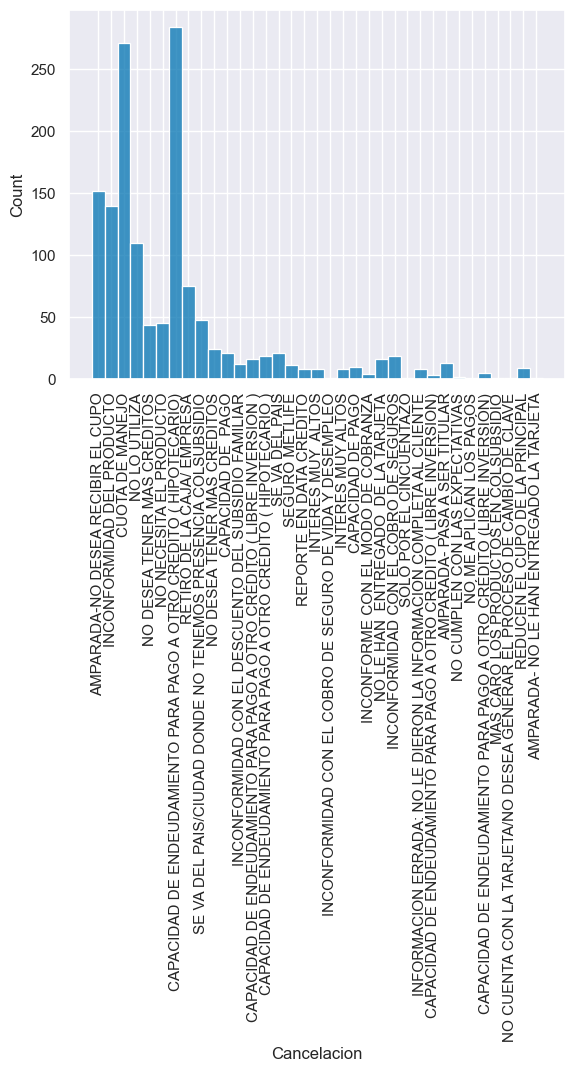

Gestionable  registros:  1412


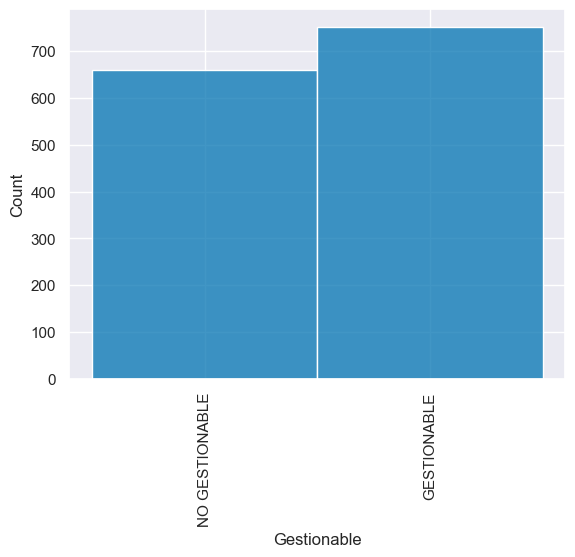

Retencion  registros:  1412


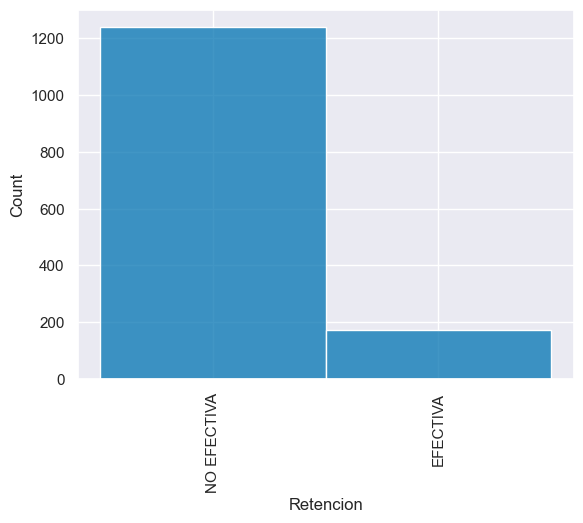

TIPO  registros:  1412


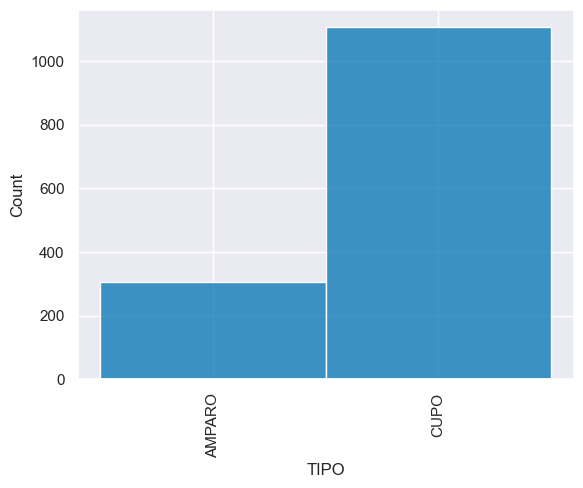

Target  registros:  50001


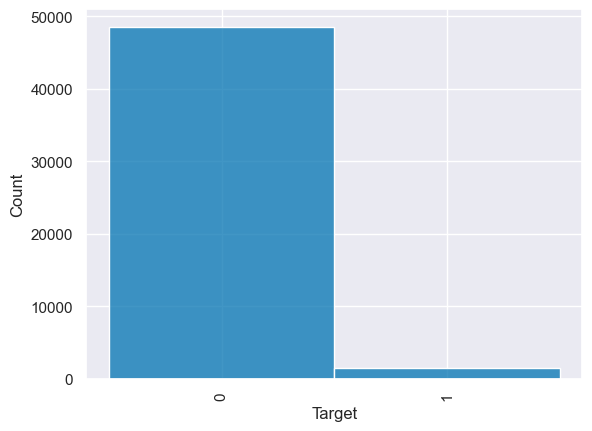

categoria  registros:  50001


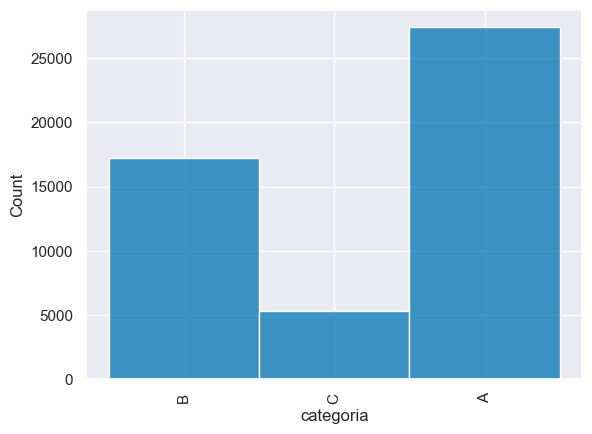

segmento  registros:  50001


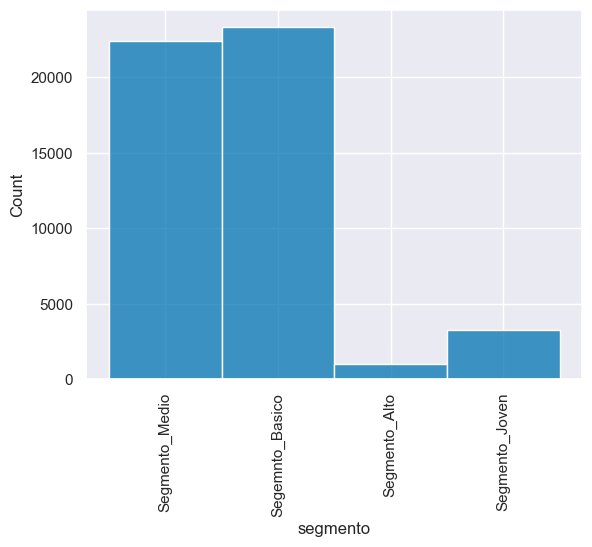

nivel_educativo  registros:  50001


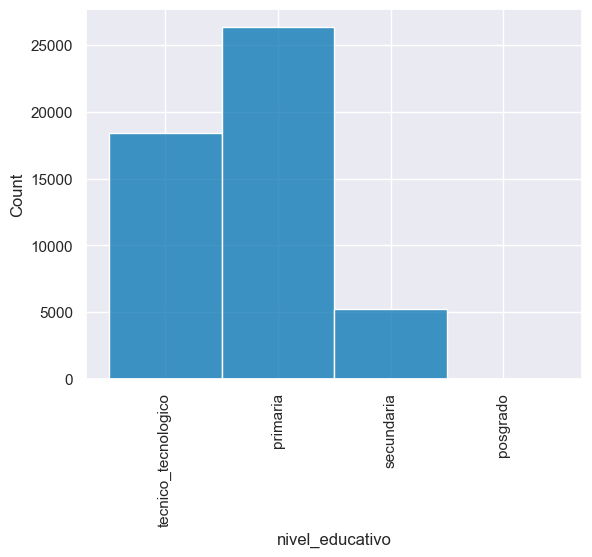

estado_civil  registros:  50001


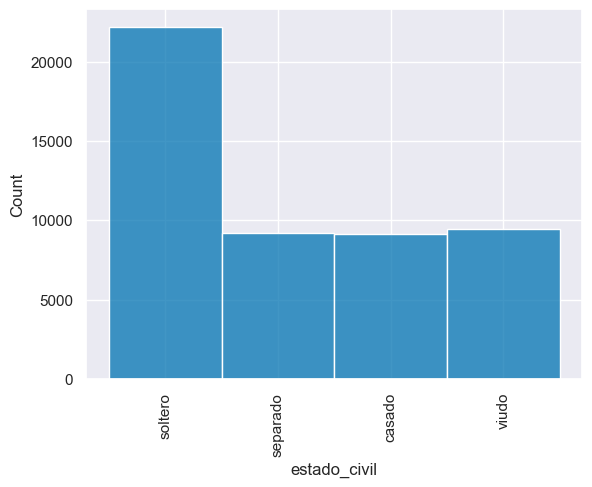

Genero  registros:  50001


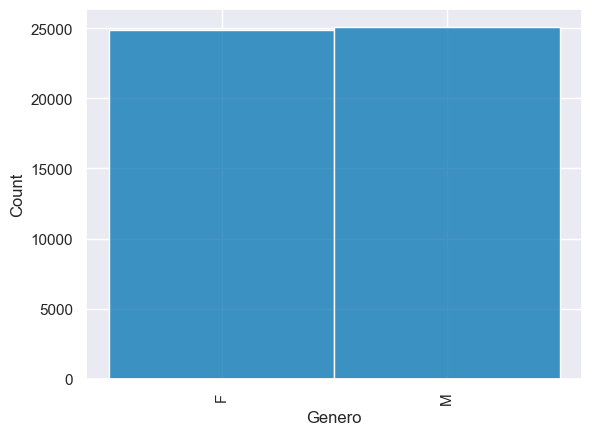

PAC  registros:  50001


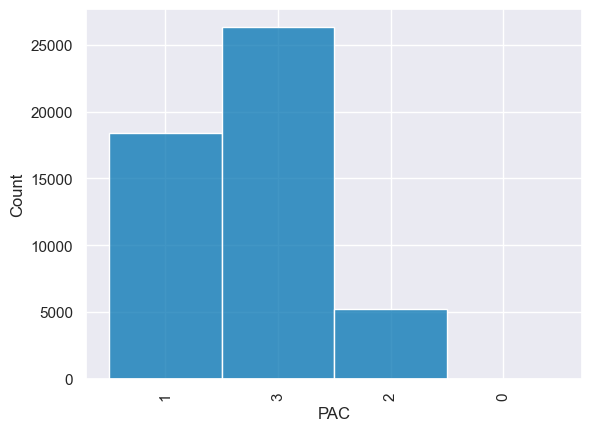

contrato  registros:  50001


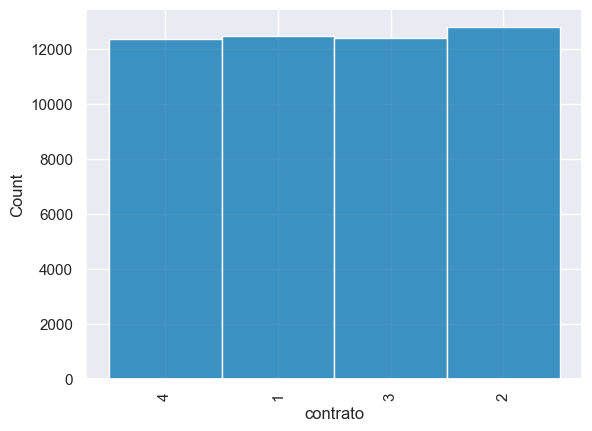

estrato  registros:  4116


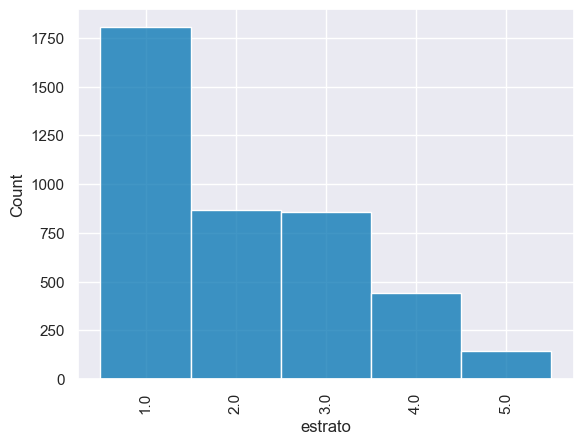

cuota_monetaria  registros:  50001


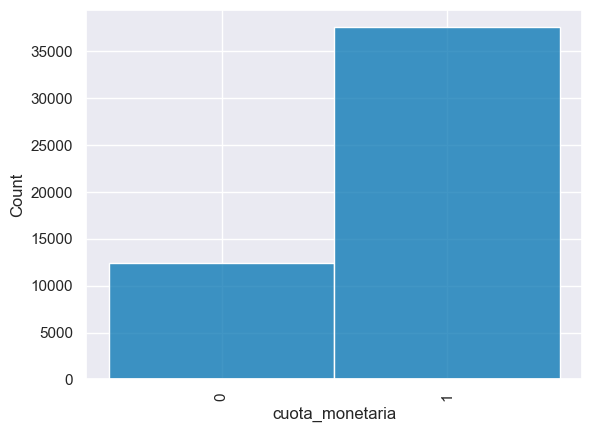

sub_vivenda  registros:  50001


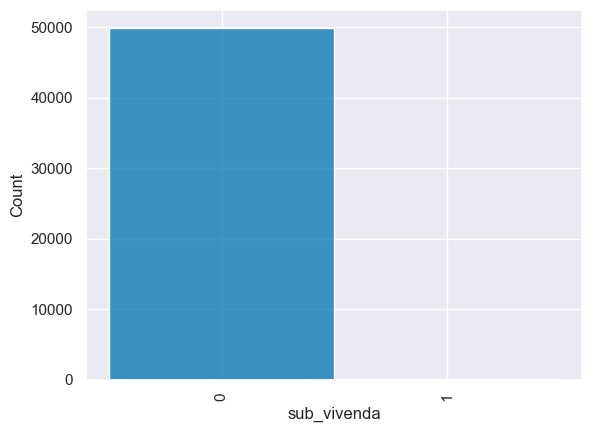

bono_lonchera  registros:  50001


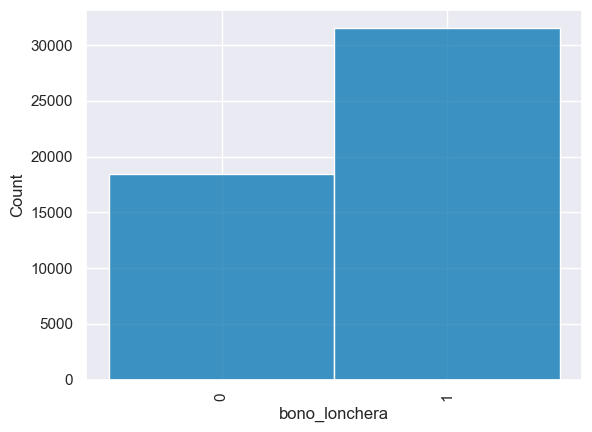

In [18]:

for i in ['Cancelacion','Gestionable','Retencion','TIPO','Target','categoria','segmento','nivel_educativo','estado_civil','Genero','PAC','contrato','estrato','cuota_monetaria', 'sub_vivenda','bono_lonchera']:
    print(i,' registros: ',df_train_consolidado[i].notnull().sum())
    sns.set_theme(style="darkgrid")
    sns.set_palette("colorblind")
    sns.histplot(df_train_consolidado[i])
    plt.xticks(rotation=90)
    plt.show()

Disponible.Avances  registros:  50001


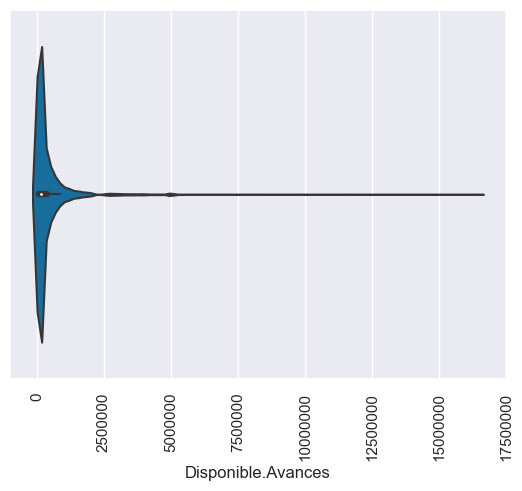

Limite.Avances  registros:  50001


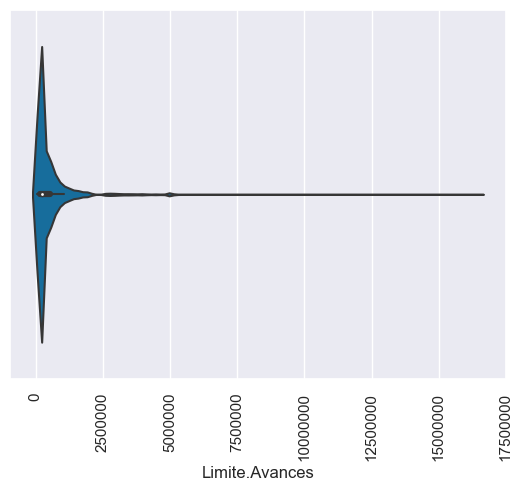

Total.Intereses  registros:  50001


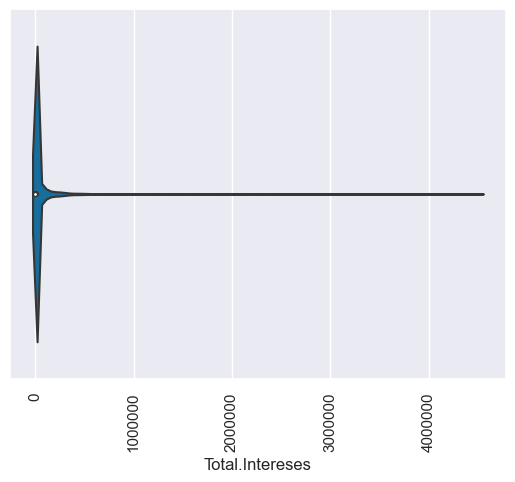

Saldos.Mes.Ant  registros:  50001


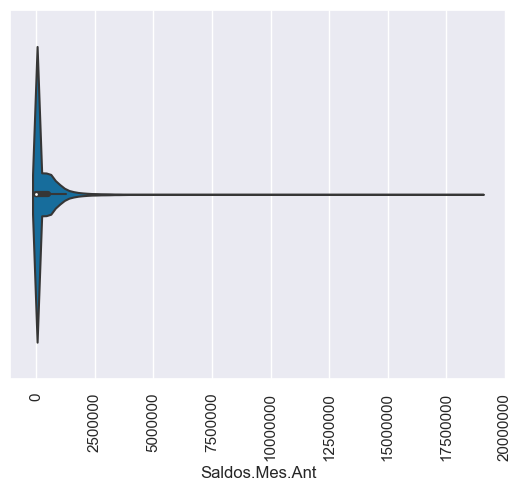

Pagos.Mes.Ant  registros:  50001


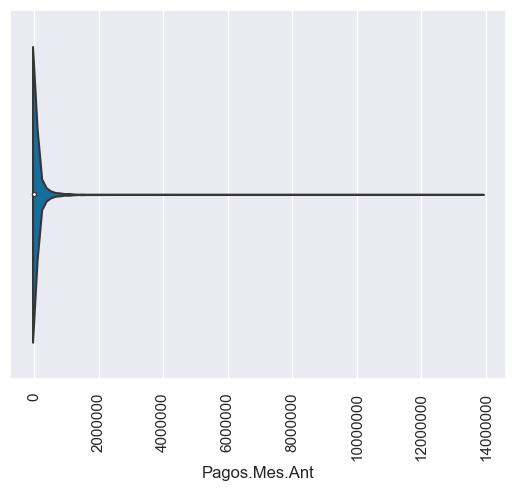

Vtas.Mes.Ant  registros:  50001


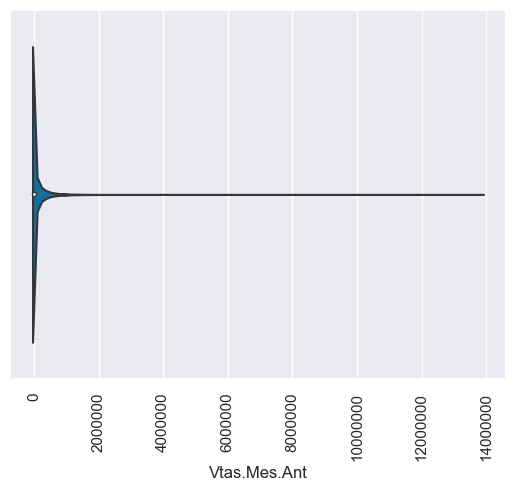

Edad.Mora  registros:  50001


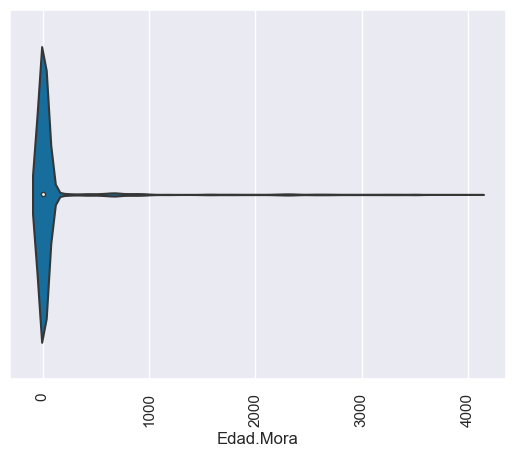

Limite.Cupo  registros:  50001


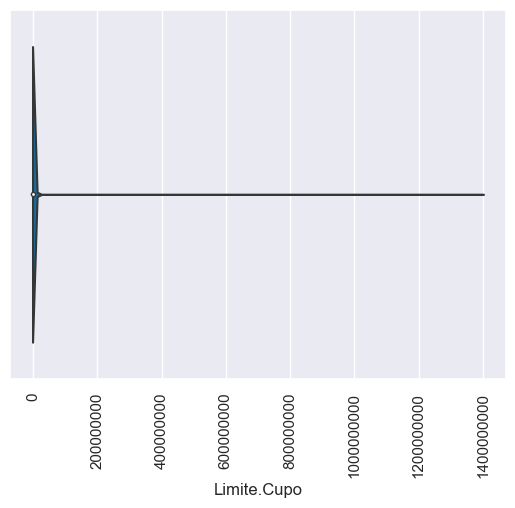

Pago.del.Mes  registros:  50001


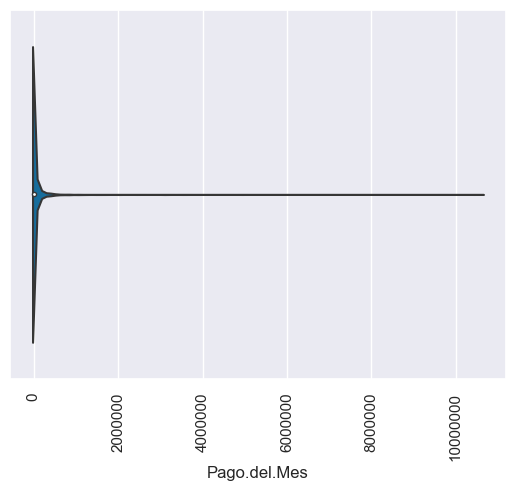

Pago.Minimo  registros:  50001


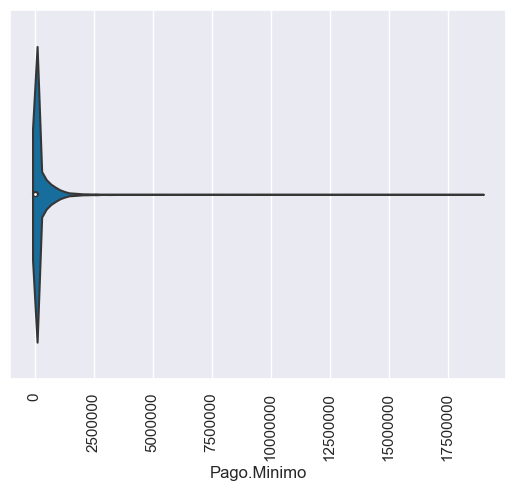

Vr.Mora  registros:  50001


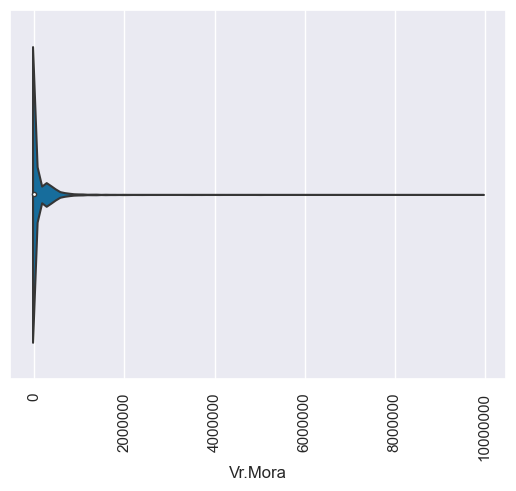

Vr.Cuota.Manejo  registros:  50001


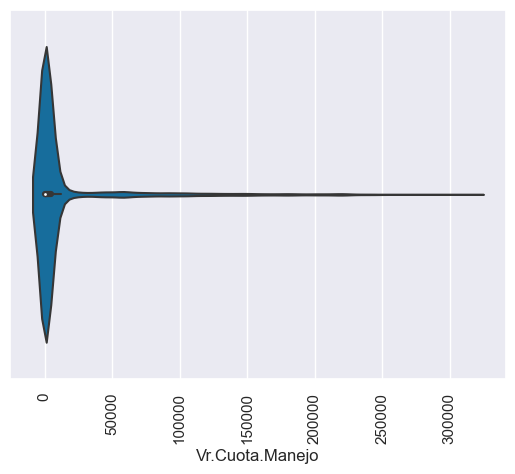

Saldo  registros:  50001


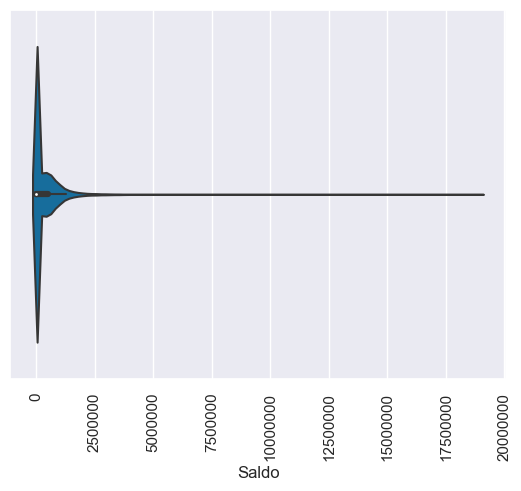

edad  registros:  50001


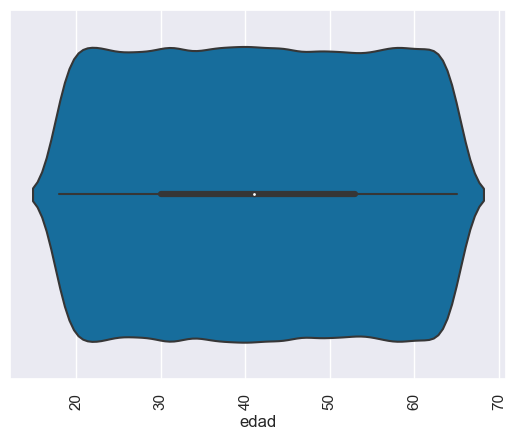

In [19]:
for i in metricas+metricas_demo:
    print(i,' registros: ',df_train_consolidado[i].notnull().sum())
    sns.set_theme(style="darkgrid")
    sns.set_palette("colorblind")
    sns.violinplot(x=df_train_consolidado[i], orient = 'h')
    plt.xticks(rotation=90)
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

Fecha.Expedicion  registros:  50001


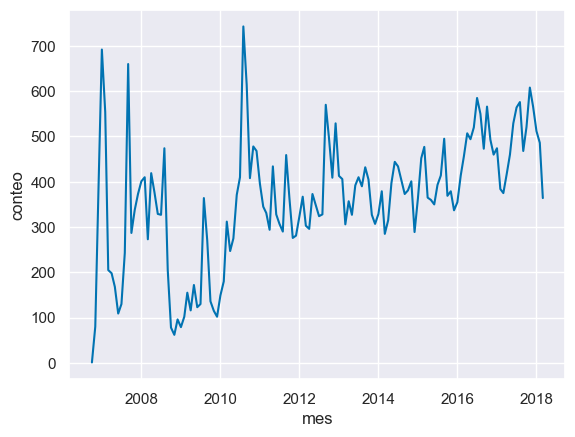

Fecha.Proceso  registros:  50001


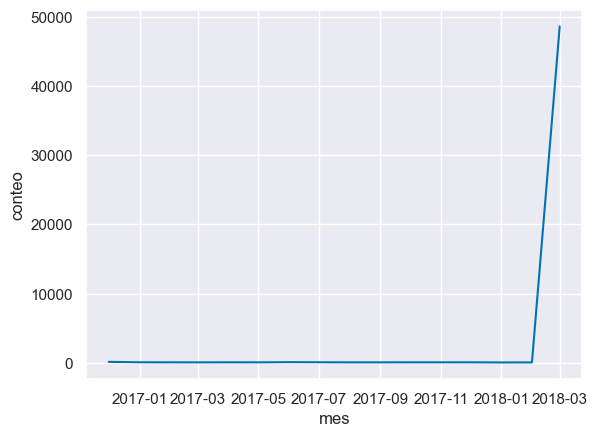

ANO_MES  registros:  1412


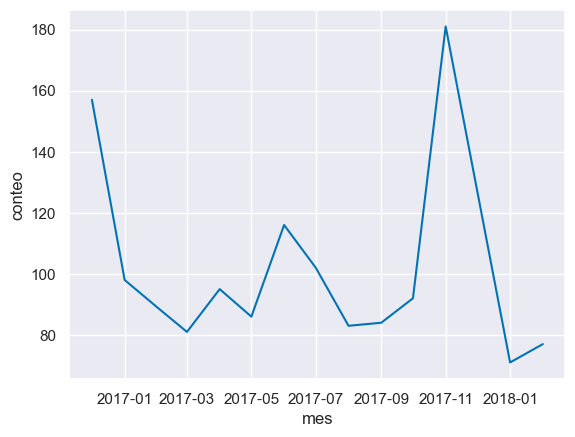

In [20]:
for i in ['Fecha.Expedicion','Fecha.Proceso','ANO_MES']:
    print(i,' registros: ',df_train_consolidado[i].notnull().sum())
    temp = df_train_consolidado.copy()
    temp['mes'] = temp[i]+ pd.offsets.MonthBegin(-1)
    temp = temp.groupby('mes').agg(conteo = ('id','count')).reset_index()
    sns.set_theme(style="darkgrid")
    sns.set_palette("colorblind")
    sns.lineplot(temp, x='mes', y='conteo')
    plt.show()

* Nuevas variables pertinentes

Se trataran de construir algunas variables que no generen una mayor multicolinealidad en el dataset, teniendo en cuenta que varias de ellas guardan ya bastante relación entre si

porc_avances  registros:  50001


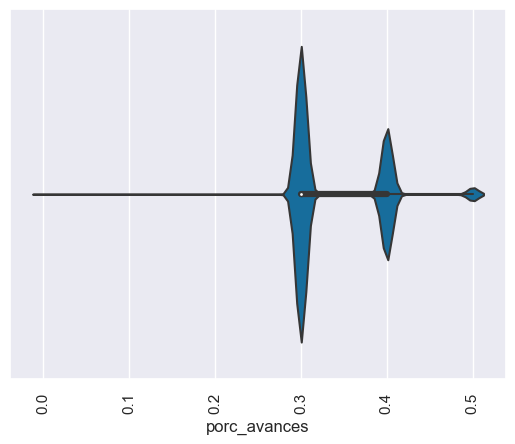

In [21]:
df_train_consolidado['porc_avances'] = df_train_consolidado['Limite.Avances']/df_train_consolidado['Limite.Cupo']
print('porc_avances',' registros: ',df_train_consolidado['porc_avances'].notnull().sum())
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.violinplot(x=df_train_consolidado['porc_avances'], orient = 'h')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

Tras Realizar un breve análisis univariado nos podemos dar cuenta que:

- Fue necesario  estandarizar algunas variables dejándolas solamente en mayúsculas
- Se tienen algunos valores atipicos especialmente en las variables métricas, por lo cual se recomienda gestionar las observaciones anomalas durante la construcción del modelo
- Apróximadamente el 3% de los clientes en la base de datos tienen una cancelación manifestada
- La labor de retención tiene una baja efectividad
- los pincipales motivos por los cuales los clientes manifiestan que quieren cancelar su cupo es debido a la necesidad de librear capacidad de endeudamiento para pagar un crédito hipotecario, e inconformidad con la cuota de manejo
- Con el pasar del tiempo ha habido un crecimiento en la expedición de cupos, mientras que las cancelaciones se han mantenido relativamente estables, exceptuando el mes de 11-2017 en donde hubo un crecimiento atipico en las cancelaciones


### <font color='orange'>**c/d) Construcción del modelo y evaluación de los mismos**</font>

1) Modelo de Cancelación (supervisado)
* Normalización de las variables
* División conjunto de Train y Validate
* Seleccion/Consolidación de Variables (Dimensionality Reduction)
* Prueba de Multiples modelos (Logistic Regression, Support Vector Machines (SVM), Random Forest, Neural Networks, k-Nearest Neighbor (kNN))
* Selección del modelo o modelos Idoneos (Metrica AUC / PRECISION / RECALL)
* Ensamble de los modelos

In [22]:
from pycaret.classification import *

Haciendo uso de la libreria PYCARET, podemos construir multiples modelos de forma rápida, parametrizando todas aquellas responsabilidades necesarias de cara al tratamiento de los datos que se vieron eran necesarias en el momento que hicimos el EDA.

A continuación se muestra como podemos configurar la estrategia de validación cruzada (Subconjuntos de training y Validate), configurar la estrategia de Balanceo de muestras de Training, La estrategia para remover datos atípicos, la normalización de variables métricas, el tratamiento ante la multicolinealidad, la metodología para reducir dimensiones, y de ser necesario, se puede configurar la opcion para trabajar en paralelo (n_jobs)

In [23]:
s = setup(df_train_consolidado,
        ignore_features = ['id','Cancelacion','Gestionable','Retencion','TIPO','ANO_MES','Fecha.Proceso'], # Campos que no se tendrán en cuenta dado que son bien sea el identificador o campos que no tenemos antes e que un cliente manifieste su cancelación (pensando en producción)
         target = 'Target' #Definimos la variable Fallo

         ,fold_strategy = 'kfold' #Definimos lla estrategia para validacion cruzada creando a partir del dataset de Train, varios dataset de Validation
         ,fold = 10 #Definimos el numero total de folds a realizar
         ,train_size = 0.7

        ,fix_imbalance= True # SMOTE por defecto
         ,fix_imbalance_method = 'SMOTE' #Balanceamos la muesra utilizando la metodología SMOTE (crear muesrtas sintéticas aleatorias en función de la distribución actual)

         ,remove_outliers = True
         ,outliers_method = 'iforest'
         ,outliers_threshold = 0.05

         ,normalize = True # normalizamos las variables metricas con z score para evitar una alta varianza entre las variables y que se nos sesguen los resultados al comportamiento de alguna en particular
         ,normalize_method = 'zscore'

         ,remove_multicollinearity = True
         ,multicollinearity_threshold = 0.9 # Variables con correlación superior al 90% son eliminadas, solo permanece la que tenga mayor corr con Y

         ,feature_selection_method = 'univariate' #Definimos el feature selecction: rankeo de las variables por medio de un test de Chi2
         ,n_features_to_select = 0.8 # Maximo nos podemos quedar con el 80% de las variables X que tenemos ordenadas según su importancia
                  
        
         ,session_id = 123 #semilla

         ,n_jobs = -1
         #,use_gpu = True
         
         )

Con una simple linea de codigo, luego de la configuración inicial, seleccionamos aquellos modelos de clasificación que queremos desarrollar, donde los seleccionados son:

'lightgbm' : Light Gradient Boosting Machine	

'dt': Árboles de Decisión

'ada': Ada boost Clasifier (trees)

'rf': Random Forest

'lr': Regresión Logistica

'svm': Support Vector Machines - Classifier


In [29]:
best = compare_models(sort = 'F1'   
                      ,include=['lightgbm','dt','ada','rf','lr','svm']           
                    )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:02:41
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Luego de correr los modelos, la librería nos entrega las principales métricas de desempeño (promedio) para los modelos de clasificación con un threshold sobre la probabilidad por defecto de 0.5, esto nos puede dar una idea sobre cuales podría ser el que tiene un mejor desempeño

In [30]:
results = pull() 
results.sort_values('F1', ascending= False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9757,0.9284,0.3354,0.6321,0.4374,0.4261,0.4491,1.377
dt,Decision Tree Classifier,0.9523,0.6587,0.3477,0.2520,0.2915,0.2676,0.2716,0.713
ada,Ada Boost Classifier,0.9615,0.8755,0.2761,0.3034,0.2877,0.2681,0.2691,0.747
rf,Random Forest Classifier,0.9723,0.8945,0.1571,0.5283,0.2415,0.2316,0.2773,0.799
lr,Logistic Regression,0.6570,0.7726,0.7576,0.0598,0.1108,0.0617,0.1421,0.712
svm,SVM - Linear Kernel,0.6408,0.0000,0.7881,0.0592,0.1101,0.0608,0.1451,0.700


Con lo anterior y priorizando por el F1 Score, encontramos que el modelo que mejor desepeño promedio tiene es el LGBM, por lo cual lo construiremos de forma independiente

In [31]:
lgbm = create_model('lightgbm')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:16:15
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9780,0.9355,0.3483,0.6200,0.4460,0.4357,0.4547
1,0.9751,0.9489,0.3187,0.5370,0.4000,0.3882,0.4020
2,0.9763,0.9297,0.3265,0.6531,0.4354,0.4246,0.4515
3,0.9726,0.9170,0.2947,0.4912,0.3684,0.3553,0.3675
4,0.9769,0.9269,0.3846,0.7018,0.4969,0.4861,0.5093
5,0.9723,0.9465,0.3271,0.5833,0.4192,0.4061,0.4241
6,0.9757,0.9031,0.3265,0.6275,0.4295,0.4184,0.4419
7,0.9769,0.9408,0.3540,0.8333,0.4969,0.4870,0.5344
8,0.9774,0.9209,0.3407,0.6200,0.4397,0.4292,0.4494


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Como se observa, en la tabla anterior, se nos muestra el desempeño que ha tenido el modelo a lo largo de el K-Fold Cross Validation que configuramos en el inicio, y a continuación construiremos la curva ROC, y la estimación de la importancia que tienen cada una de las variables incluidas en el modelo

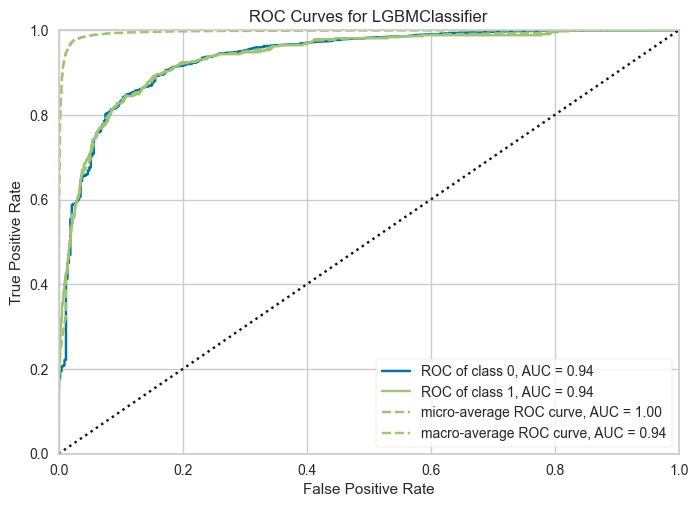

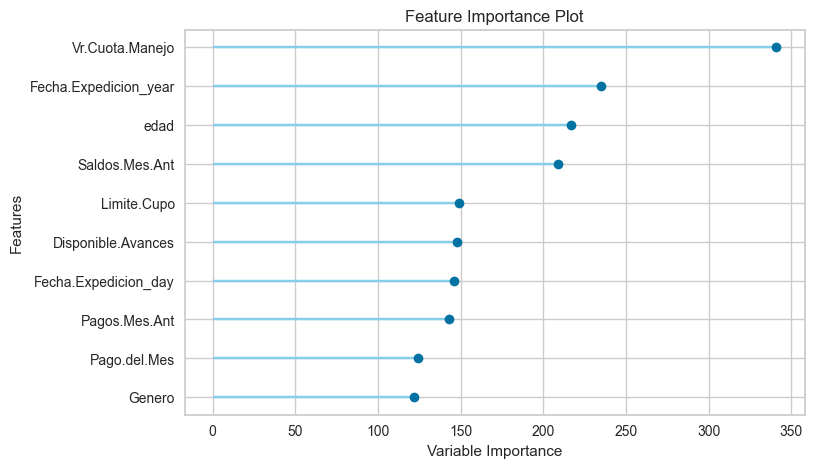

In [89]:
plot_model(lgbm, plot = 'auc') 
plot_model(lgbm, plot = 'feature')


Como se observa, tenemos un AUC del 0.94 lo cual es muy positivo, no obstante al estar tratando con muestras imbalanceadas, es importante plantear alguna metodología que nos permita seleccionar el Threshold óptimo sobre la probabilidad (se verá más adelante)

Por su parte en el gráfico de importancia de las variables, nos damos cuenta que la variable más relevante es el Valor que tiene la cuota de manejo, seguido por el año en el cual fue emitido el cupo y luego por la Edad del cliente

* Optimización del threshold

Sobre el conjunto de Validación que se ha construido a partir de los datos de Train, estimaremos manualente tanto la sensitividad como especificidad del modelo, todo con el ánimo de utilizar la metodología de GMEANS para seleccionar el threshold óptimo

In [139]:
prueba_val = get_config('X_test').join(get_config('y_test'))
prueba_val = predict_model(lgbm, data=prueba_val ,raw_score=True)
prueba_val

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9757,0.9371,0,0,0,0.4396,0.4581


,Fecha.Expedicion,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,...,contrato,estrato,cuota_monetaria,sub_vivenda,bono_lonchera,porc_avances,Target,prediction_label,prediction_score_0,prediction_score_1
5694,2010-03-19,2625000.0,2625000.0,0.000000,0.000000e+00,0.00,0.00,0.0,5250000.0,0.0,...,4,NaN,0,0,0,0.5,0,0,0.9913,0.0087
7540,2008-07-10,0.0,270000.0,494045.468750,1.329984e+06,0.00,0.00,60.0,900000.0,0.0,...,4,NaN,1,0,1,0.3,0,0,0.9996,0.0004
30169,2014-06-03,225000.0,225000.0,338.959991,5.285100e+03,41022.00,0.00,0.0,750000.0,0.0,...,3,NaN,1,0,1,0.3,0,0,0.9216,0.0784
13879,2016-07-27,560000.0,560000.0,0.000000,0.000000e+00,0.00,0.00,0.0,1400000.0,0.0,...,4,NaN,0,0,0,0.4,0,0,0.9750,0.0250
33377,2016-02-03,210000.0,210000.0,0.000000,0.000000e+00,0.00,0.00,0.0,700000.0,0.0,...,1,NaN,1,0,1,0.3,0,0,0.9737,0.0263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29541,2018-02-14,174000.0,174000.0,0.000000,0.000000e+00,0.00,0.00,0.0,580000.0,0.0,...,2,NaN,1,0,1,0.3,0,0,0.9975,0.0025
16826,2009-08-27,600000.0,600000.0,0.000000,0.000000e+00,0.00,0.00,0.0,1500000.0,0.0,...,1,NaN,0,0,0,0.4,0,0,0.9976,0.0024
23554,2013-04-11,120000.0,120000.0,613.940002,7.169794e+04,0.00,0.00,0.0,400000.0,0.0,...,4,NaN,1,0,1,0.3,0,0,0.9154,0.0846
23012,2014-04-25,876000.0,876000.0,20172.650391,8.962524e+05,510263.75,363323.75,0.0,2190000.0,0.0,...,4,NaN,0,0,0,0.4,0,0,0.9978,0.0022


In [120]:
th_list=[]
tp_list = []
fn_list = []
tn_list = []
fp_list = []
sensitivity_list = []
specificity_list = []
gmean_list = []
accuracy_list =[]
recall_list = []

for i in np.arange(0,1,0.01):
    
    th_list.append(i)
    
    prueba_val['prediccion'] = np.where(prueba_val['prediction_score_1']>=i,1,0)
    tp = np.where((prueba_val['prediccion'].astype('str')=='1') & (prueba_val['Target']=='1'),1,0).sum()
    tp_list.append(tp)

    fn = np.where((prueba_val['prediccion'].astype('str')=='0') & (prueba_val['Target']=='1'),1,0).sum()
    fn_list.append(fn)
   
    tn = np.where((prueba_val['prediccion'].astype('str')=='0') & (prueba_val['Target']=='0'),1,0).sum()
    tn_list.append(tn)

    fp = np.where((prueba_val['prediccion'].astype('str')=='1') & (prueba_val['Target']=='0'),1,0).sum()
    fp_list.append(fp)

    sensitivity = tp/(tp+fn)
    sensitivity_list.append(sensitivity)
    
    specificity = tn/(tn+fp)
    specificity_list.append(specificity)

    gmean = np.sqrt(sensitivity*specificity)
    gmean_list.append(gmean)

    accuracy = np.where((prueba_val['prediccion'].astype('str')=='0') & (prueba_val['Target']=='0')|
                      (prueba_val['prediccion'].astype('str')=='1') & (prueba_val['Target']=='1')
                        ,1,0).sum()/len(prueba_val['prediccion'])
    accuracy_list.append(accuracy)

    recall = tp/len(prueba_val[prueba_val['Target']=='1'])
    recall_list.append(recall)


In [121]:

nombres = ['th','tp','fp','fn','tn','sensitivity', 'specificity','gmean','accuracy','recall']
th_opt = pd.DataFrame(list(zip(th_list,tp_list,fp_list, fn_list,tn_list,sensitivity_list,specificity_list,gmean_list,accuracy_list,recall_list)), columns=nombres)
th_opt.sort_values('gmean', ascending= False)

,th,tp,fp,fn,tn,sensitivity,specificity,gmean,accuracy,recall
3,0.03,375,2176,49,12401,0.884434,0.850724,0.867415,0.851677,0.884434
5,0.05,352,1487,72,13090,0.830189,0.897990,0.863424,0.896074,0.830189
4,0.04,359,1751,65,12826,0.846698,0.879879,0.863129,0.878941,0.846698
6,0.06,346,1286,78,13291,0.816038,0.911779,0.862581,0.909073,0.816038
2,0.02,392,2950,32,11627,0.924528,0.797626,0.858736,0.801213,0.924528
...,...,...,...,...,...,...,...,...,...,...
96,0.96,6,1,418,14576,0.014151,0.999931,0.118954,0.972069,0.014151
97,0.97,2,0,422,14577,0.004717,1.000000,0.068680,0.971869,0.004717
98,0.98,1,0,423,14577,0.002358,1.000000,0.048564,0.971802,0.002358
0,0.00,424,14577,0,0,1.000000,0.000000,0.000000,0.028265,1.000000


In [122]:
from numpy import argmax
ix = argmax(th_opt['gmean'])
print('Best Threshold=%f, G-Mean=%.3f' % (th_opt['th'][ix], th_opt['gmean'][ix]))

Best Threshold=0.030000, G-Mean=0.867


<Axes: xlabel='specificity', ylabel='sensitivity'>

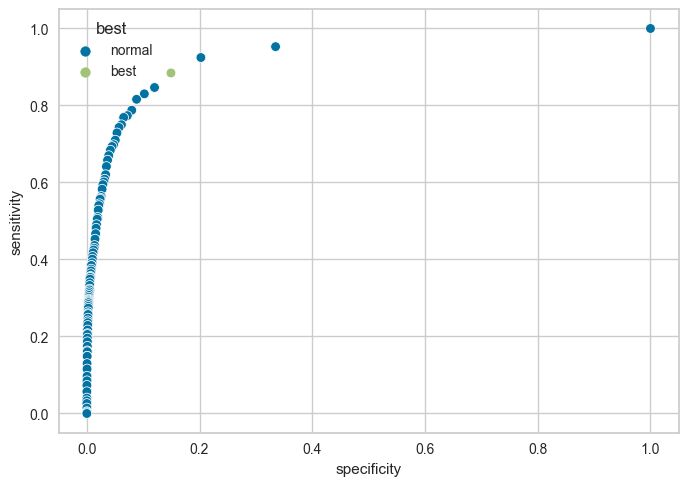

In [123]:
th_opt['best'] = np.where(th_opt['th']== th_opt['th'][ix],'best','normal')
sns.scatterplot(data=th_opt, y=th_opt['sensitivity'], x=1-th_opt['specificity'], hue='best')

Conclusión: Nos damos cuenta que el punto donde se maximiza nuestro GMEANS, y por ende es el óptimo de nuestra curva ROC, es cuando nuestro TH es igual a 0.03

### <font color='orange'>**e2) Despliegue modelo de clasificacion**</font>

En este último paso construiremos los archivos que comprimen nuestros mejores modelos (.pkl), que a su vez son los que podriamos utilizar en el momento de disponibilizar un API bien sea en Docker o en una Máquina virtual (EC2) para que posteriormente pueda seguir siendo consumido, así mismo probaremos su desempeño con la data de test

In [124]:
save_model(lgbm, 'best_clf') # creará nuestro PKL para posteriormente poder cargarlo y desplegarlo

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\camil\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['Fecha.Expedicion'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('nu...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20, min_child_weight=0.001,
    

Cargamos nuestro modelo para utilizarlo

In [125]:
predictor = load_model('best_clf')

Transformation Pipeline and Model Successfully Loaded


Ahora sobre los datos de TEST (Datos que no ha conocido nuestro modelo), calcularemos nuestra probabilidad y trataremos de emular las métricas de Accuracy y Recall con el ánimo de garantizar que al utilizar el modelo sobre unos datos completamente desconocidos, este no pierda su nivel de desempeño

In [134]:
df_test_consolidado['porc_avances'] = df_test_consolidado['Limite.Avances']/df_test_consolidado['Limite.Cupo'] # Creamos una variable manual que incluimos
test_deploy= predict_model(predictor, data=df_test_consolidado ,raw_score=True) # Predecimos sobre los datos de Test
test_deploy

,id,Fecha.Expedicion,Cancelacion,Gestionable,TIPO,ANO_MES,Fecha.Proceso,Disponible.Avances,Limite.Avances,Total.Intereses,...,contrato,estrato,cuota_monetaria,sub_vivenda,bono_lonchera,porc_avances,target_simulado,prediction_label,prediction_score_0,prediction_score_1
0,50002,2007-06-14,NaN,NaN,NaN,NaT,2018-04-01,150000.0,150000.0,0.0,...,1,NaN,1,0,1,0.3,0,0,0.9979,0.0021
1,50003,2007-09-18,NaN,NaN,NaN,NaT,2018-04-01,150000.0,150000.0,0.0,...,3,NaN,1,0,1,0.3,0,0,0.9955,0.0045
2,50004,2007-04-12,NaN,NaN,NaN,NaT,2018-04-01,540000.0,540000.0,0.0,...,1,NaN,0,0,0,0.4,0,0,0.9960,0.0040
3,50005,2006-11-17,NaN,NaN,NaN,NaT,2018-04-01,252000.0,252000.0,0.0,...,2,NaN,1,0,1,0.3,0,0,0.9980,0.0020
4,50006,2007-01-31,NaN,NaN,NaN,NaT,2018-04-01,760000.0,760000.0,0.0,...,4,NaN,0,0,0,0.4,0,0,0.9940,0.0060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,54998,2018-03-27,NaN,NaN,NaN,NaT,2018-04-01,45000.0,45000.0,0.0,...,4,NaN,1,0,1,0.3,0,0,0.9564,0.0436
4997,54999,2008-06-06,CAPACIDAD DE ENDEUDAMIENTO PARA PAGO A OTRO CR...,No gestionable,AMPARO,2017-01-01,2017-01-01,45000.0,45000.0,0.0,...,2,NaN,1,0,1,0.3,1,0,0.6379,0.3621
4998,55000,2016-10-03,NaN,NaN,NaN,NaT,2018-04-01,45000.0,45000.0,0.0,...,1,NaN,1,0,1,0.3,0,0,0.6373,0.3627
4999,55001,2016-10-03,NO NECESITA EL PRODUCTO,Gestionable,AMPARO,2017-06-01,2017-06-01,45000.0,45000.0,0.0,...,4,NaN,1,0,1,0.3,1,0,0.5286,0.4714


Como se muestra a continuación, al utilizar el modelo sobre unos datos completamente desconocidos nuestro accuracy es de 85.6% y nuestro recall de 86.86%, manteniendo de esta forma el desempeño del modelo

In [136]:
test_deploy['Target'] = np.where(test_deploy['Cancelacion'].notnull(),'1','0')
test_deploy['prediccion'] = np.where(test_deploy['prediction_score_1']>=th_opt['th'][ix],'1','0')


accuracy_deploy = np.where((test_deploy['prediccion'].astype('str')=='0') & (test_deploy['Target']=='0')|
                      (test_deploy['prediccion'].astype('str')=='1') & (test_deploy['Target']=='1')
                        ,1,0).sum()/len(test_deploy['prediccion'])
tp_deploy = np.where((test_deploy['prediccion'].astype('str')=='1') & (test_deploy['Target']=='1'),1,0).sum()
recall_deploy = tp_deploy/len(test_deploy[test_deploy['Target']=='1'])

print(accuracy_deploy,recall_deploy)

0.8568286342731454 0.8686131386861314


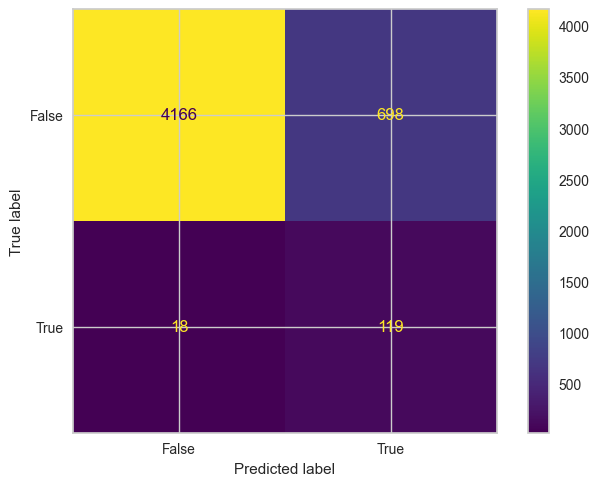

In [138]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test_deploy['Target'], test_deploy['prediccion'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

2) Modelo de segmentación (no supervisado)
* Normalización de las variables
* Prueba de Multiples modelos (k-means, clusters jerarquicos)
* Selección del modelo o modelos Idoneos (silhouette score)

A continuación configuraremos el modelo de segmentación, en este estableceremos la metodología con la cual se normalizán las variables métricas, la inclusión de componentes principales donde se probó iterativamente hasta obtener un número de componentes idoneos que representaran adecuadamente la variabilidad de las caracteristicas que los componen y la facilidad para trabajar en paralelo

In [152]:
from pycaret.clustering import *
s = setup(df_train_consolidado
        
        ,ignore_features = ['id','Cancelacion','Gestionable','Retencion','TIPO','ANO_MES','Fecha.Proceso','Target'] # Campos que no se tendrán en cuenta dado que son bien sea el identificador o campos que no tenemos antes e que un cliente manifieste su cancelación (pensando en producción)

         ,normalize = True # normalizamos las variables metricas con z score para evitar una alta varianza entre las variables y que se nos sesguen los resultados al comportamiento de alguna en particular
         ,normalize_method = 'zscore'

         ,pca = True #Definimos 
         ,pca_components = 5 # Maximo de componentes con los que nos pretendemos quedar
                         
         ,session_id = 123 #semilla

         ,n_jobs = -1
         #,use_gpu = True
         
    )

In [198]:
kmeans = create_model('kmeans', num_clusters = 5)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,00:14:37
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6387,26489.4538,0.7777,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.6387,26489.4538,0.7777,0,0,0


Nos damos cuenta que el Silhoutte score es de 0.63, donde entendiendo que este se mueve entre -1 y 1, y entre más cercano a 1 esté, nos indica que hay una buena agrupación de los segmentos creados por k-means

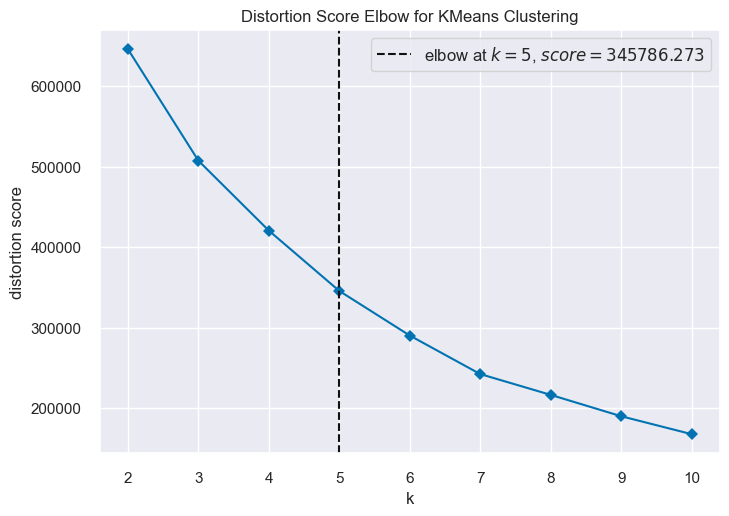

In [199]:
plot_model(kmeans, plot = 'elbow')

Así mismo evaluando el distorsion score (o grafico del codo), nos damos cuenta que el punto de inflexión está en 5, es decir el numero de segmentos ideal de segmentos a crear es de 5, ya que a partir de este punto ya no se tiene una ganancia tan grande en la reducción de la distorsión al interior de los segmentos

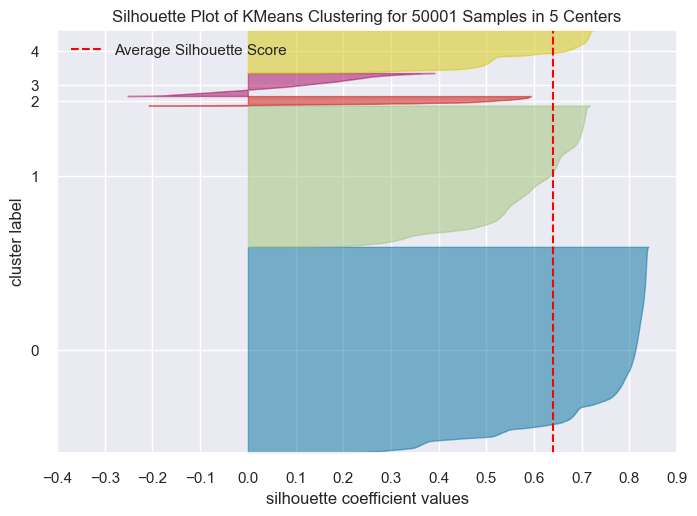

In [200]:
plot_model(kmeans, plot = 'silhouette')

En el gáfico de siluetas nos damos cuenta que 3 de los 5 segmentos tienen un coeficiente por encima del silhouette promedio, lo cual es positivo, adicionalmente son los segmentos más grandes, y si bien tenemos dos segmentos que nos indican que deberiamos abrir aun más conglomerados, son segmentos pequeños y se podrian considerar observaciones atipicas

A continuación asignaremos los segmentos

In [201]:
result = assign_model(kmeans)
result

,Fecha.Expedicion,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,...,estado_civil,Genero,PAC,contrato,estrato,cuota_monetaria,sub_vivenda,bono_lonchera,porc_avances,Cluster
0,2006-11-04,1050000.0,1050000.0,0.0,0.0,0.0,0.0,0.0,2625000.0,0.0,...,soltero,F,1,4,NaN,0,0,0,0.4,Cluster 1
1,2007-08-17,1180000.0,1180000.0,0.0,0.0,0.0,0.0,0.0,2950000.0,0.0,...,soltero,M,1,1,NaN,0,0,0,0.4,Cluster 1
2,2008-05-08,150000.0,150000.0,0.0,0.0,0.0,0.0,0.0,500000.0,0.0,...,soltero,M,3,3,NaN,1,0,1,0.3,Cluster 0
3,2006-12-21,680000.0,680000.0,0.0,0.0,0.0,0.0,0.0,1700000.0,0.0,...,soltero,M,1,4,NaN,0,0,0,0.4,Cluster 1
4,2007-09-13,3307500.0,3307500.0,0.0,0.0,0.0,0.0,0.0,6615000.0,0.0,...,separado,M,1,1,NaN,0,0,0,0.5,Cluster 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,2013-06-14,55000.0,55000.0,0.0,0.0,0.0,0.0,0.0,550000.0,0.0,...,soltero,F,3,3,NaN,1,0,1,0.1,Cluster 0
49997,2013-06-14,80000.0,80000.0,0.0,0.0,0.0,0.0,0.0,800000.0,0.0,...,soltero,M,2,2,NaN,1,0,1,0.1,Cluster 4
49998,2013-06-14,80000.0,80000.0,0.0,0.0,0.0,0.0,0.0,800000.0,0.0,...,viudo,M,2,2,NaN,1,0,1,0.1,Cluster 4
49999,2013-07-04,140000.0,140000.0,0.0,0.0,0.0,0.0,0.0,1400000.0,0.0,...,separado,F,1,3,NaN,0,0,0,0.1,Cluster 1


Con el ánimo de entender qué diferencia cada uno de los segmentos cruzaremos las variables categoricas y métricas que tenemos contra los nuevos segmentos creados:

categoria


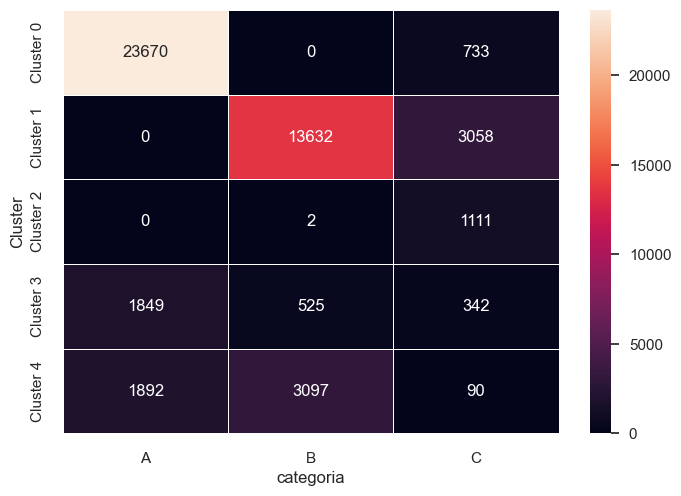

segmento


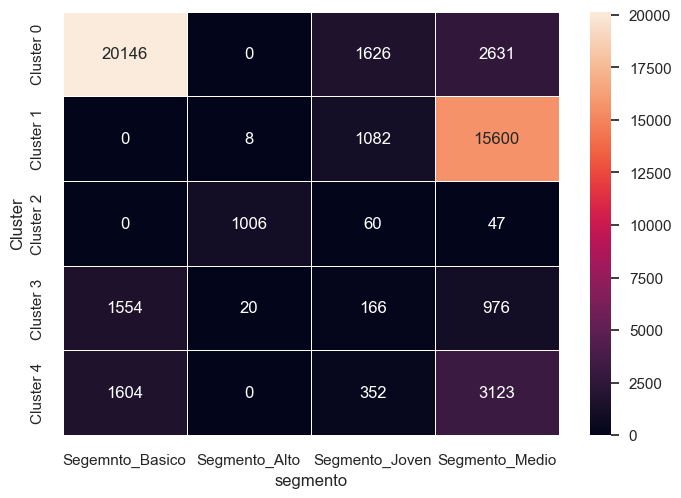

nivel_educativo


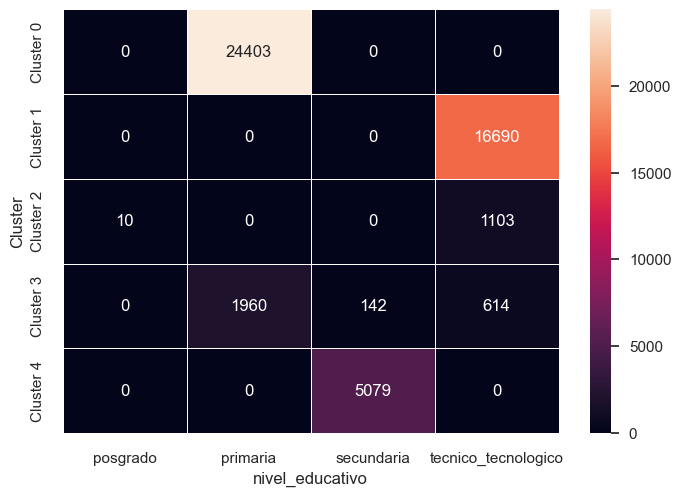

estado_civil


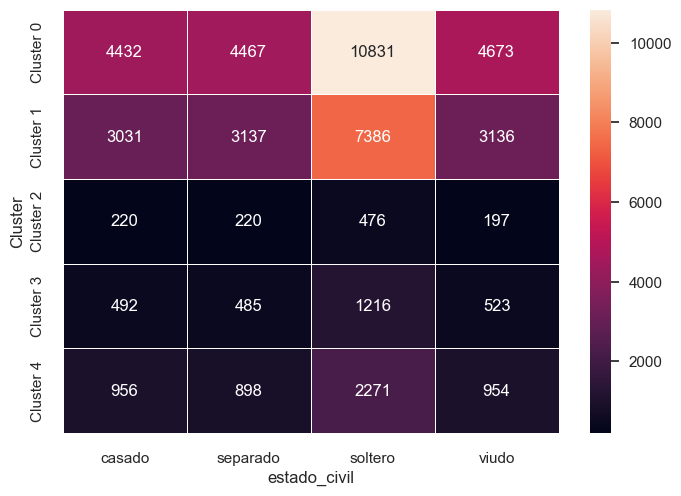

Genero


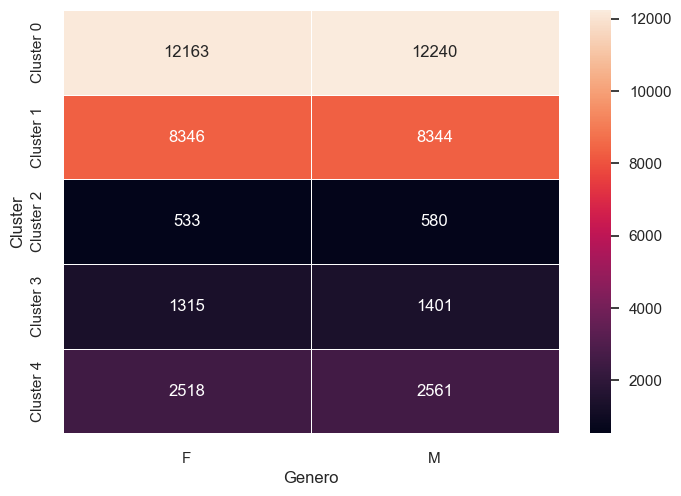

PAC


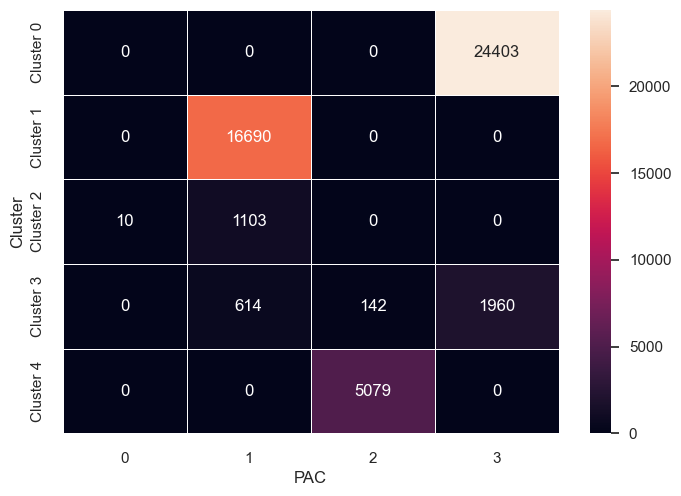

contrato


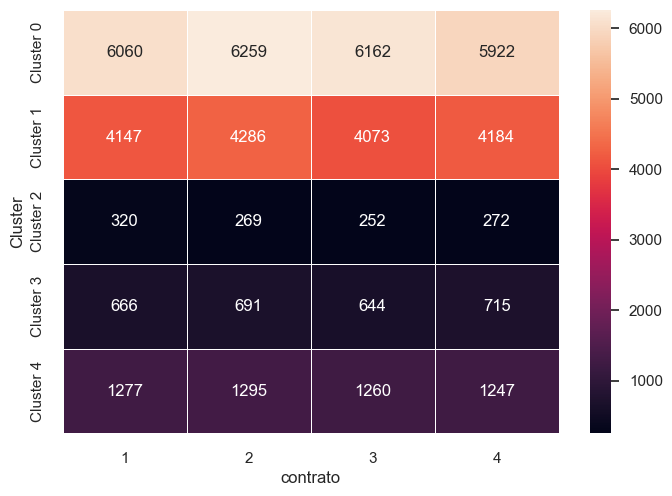

estrato


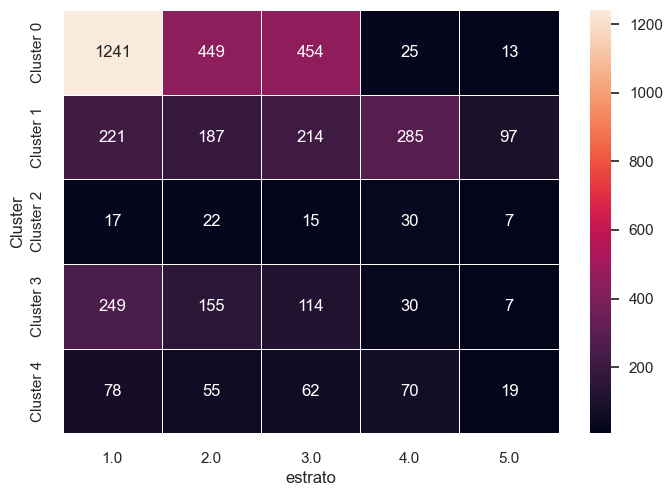

cuota_monetaria


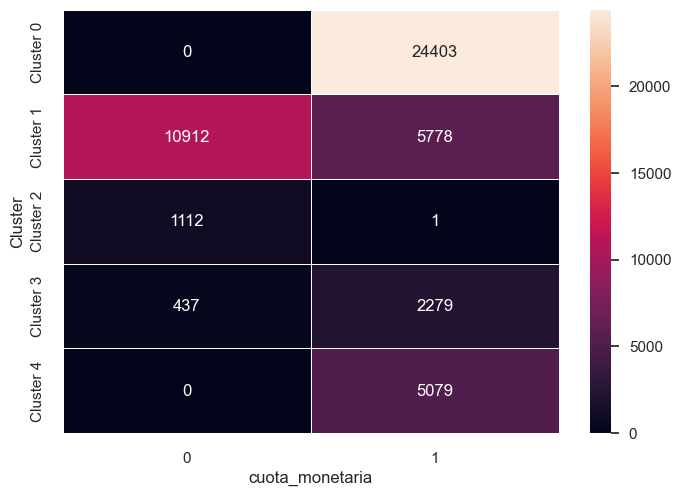

sub_vivenda


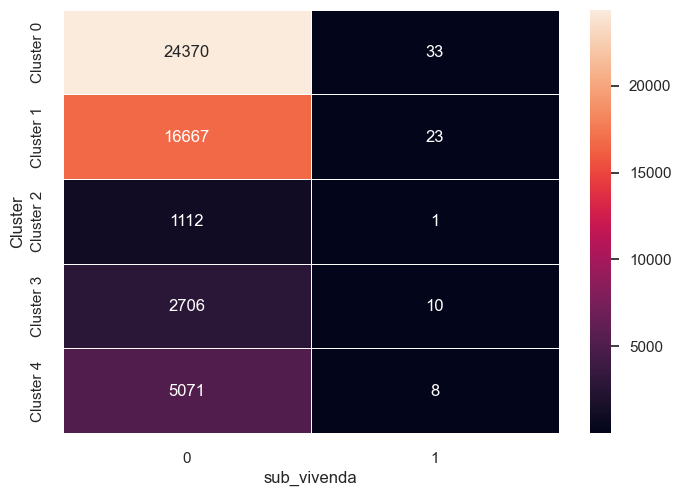

bono_lonchera


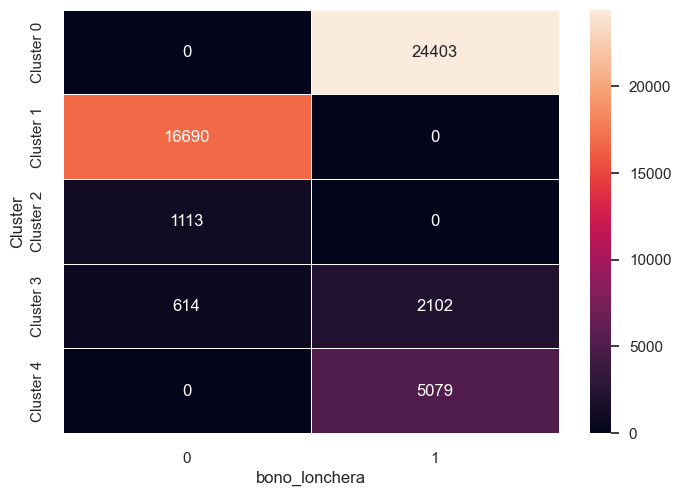

In [202]:
categoricas_interes = ['categoria','segmento','nivel_educativo','estado_civil','Genero','PAC','contrato','estrato','cuota_monetaria', 'sub_vivenda','bono_lonchera']


for i in categoricas_interes:
    print(i)
    matrix=result.pivot_table( values='Fecha.Expedicion', index='Cluster', columns=i, aggfunc='count')
    sns.heatmap(matrix, annot=True, linewidth=.5,fmt='g')
    sns.set_theme(style="darkgrid")
    sns.set_palette("colorblind")
    plt.show()


Disponible.Avances
IQR:  482194.5


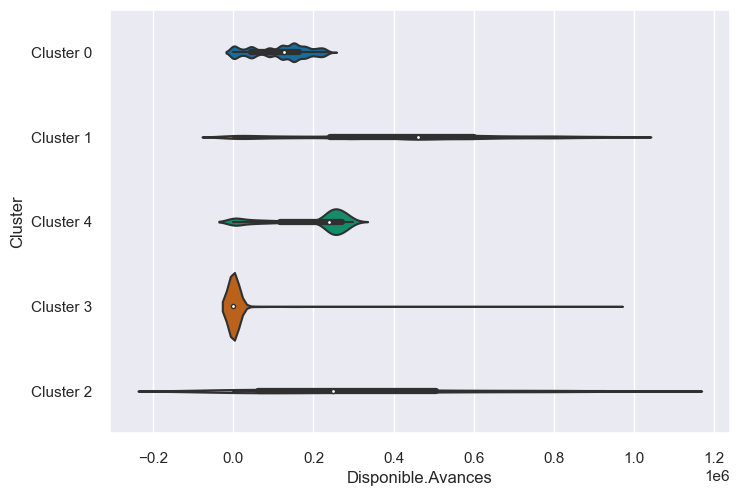

Limite.Avances
IQR:  543000.0


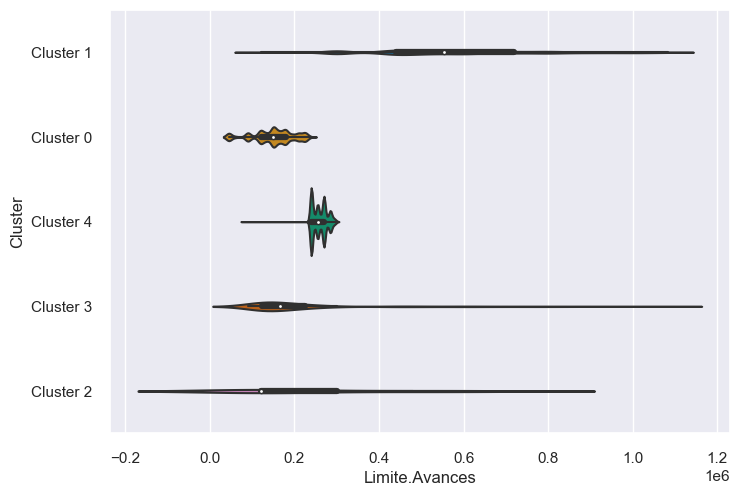

Total.Intereses
IQR:  12079.1396484375


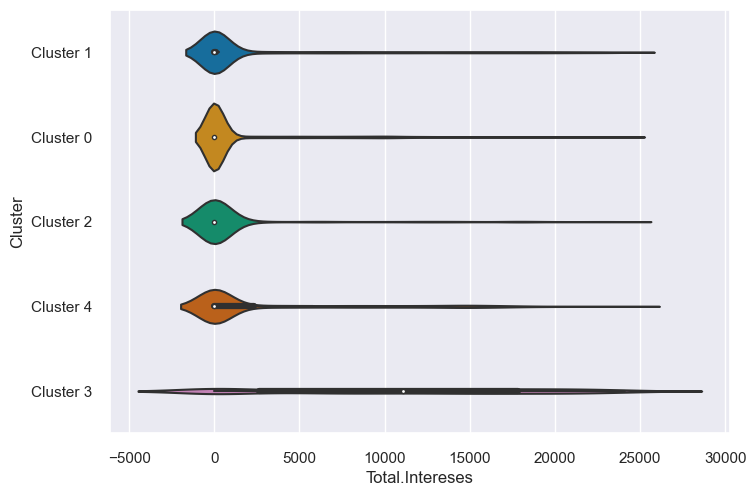

Saldos.Mes.Ant
IQR:  752586.5625


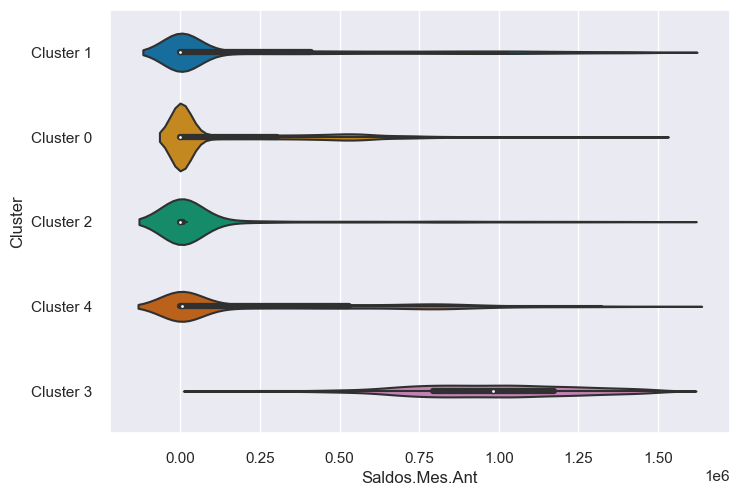

Pagos.Mes.Ant
IQR:  7422.0


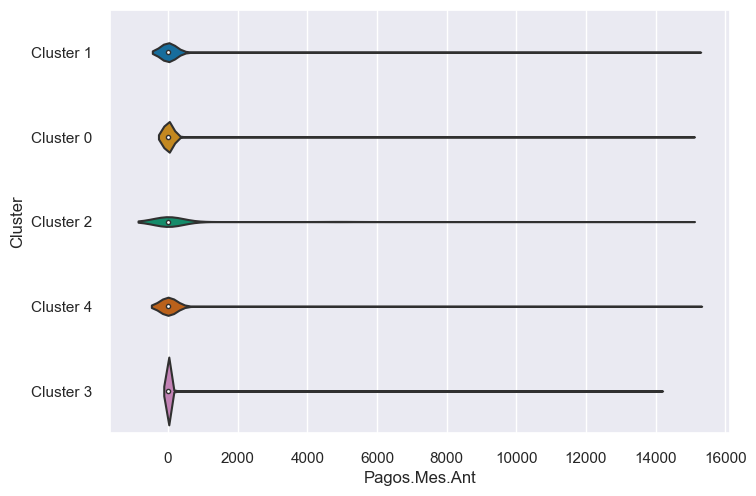

Limite.Cupo
IQR:  1182000.0


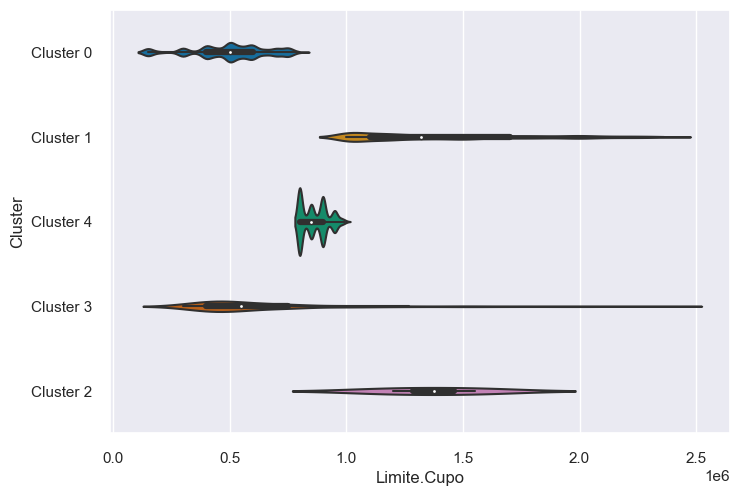

Pago.Minimo
IQR:  80809.5


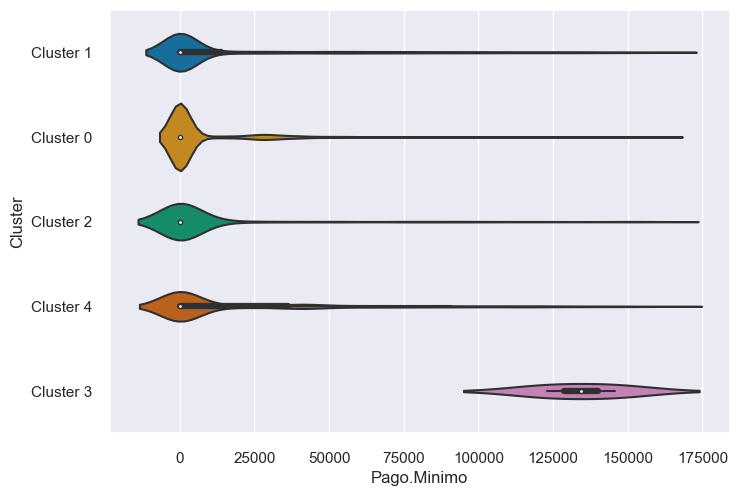

Vr.Cuota.Manejo
IQR:  7420.5


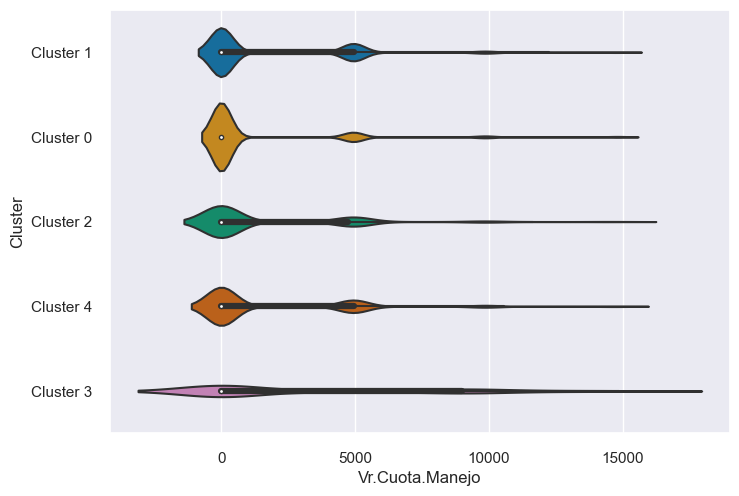

Saldo
IQR:  746562.75


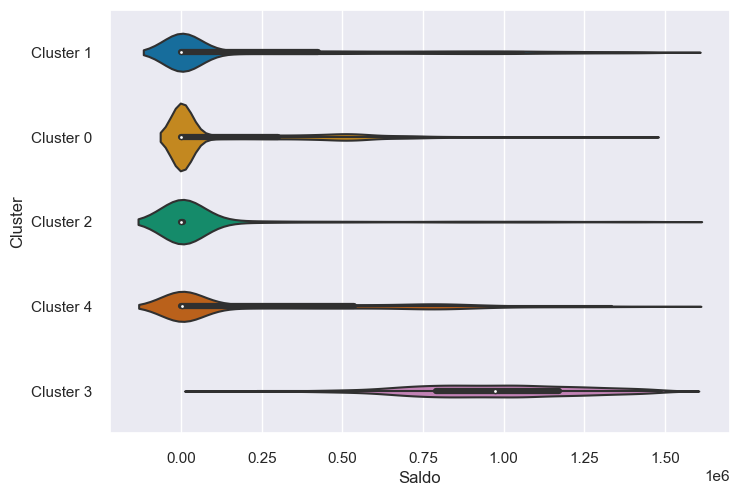

edad
IQR:  34.5


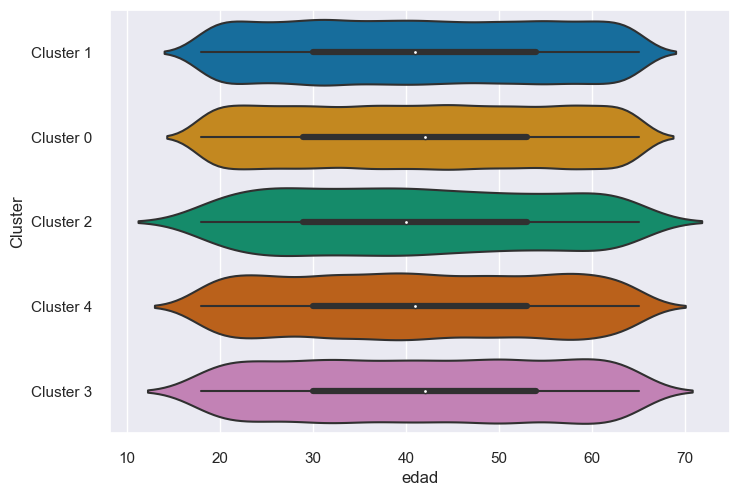

Vtas.Mes.Ant
IQR:  0.0


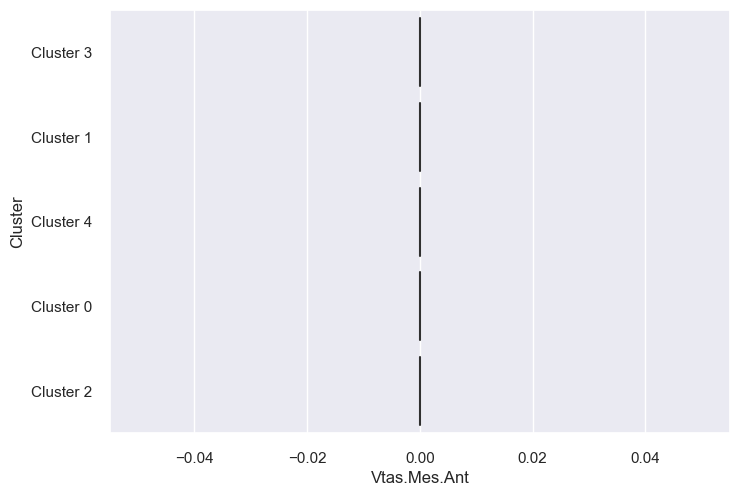

Edad.Mora
IQR:  945.0


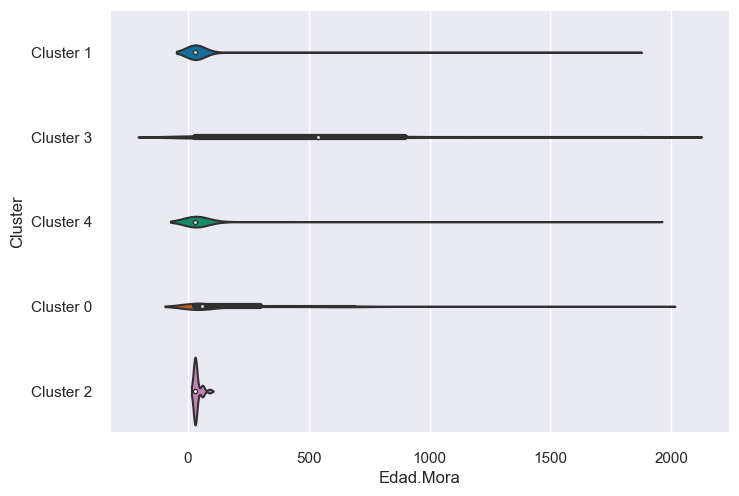

Pago.del.Mes
IQR:  0.0


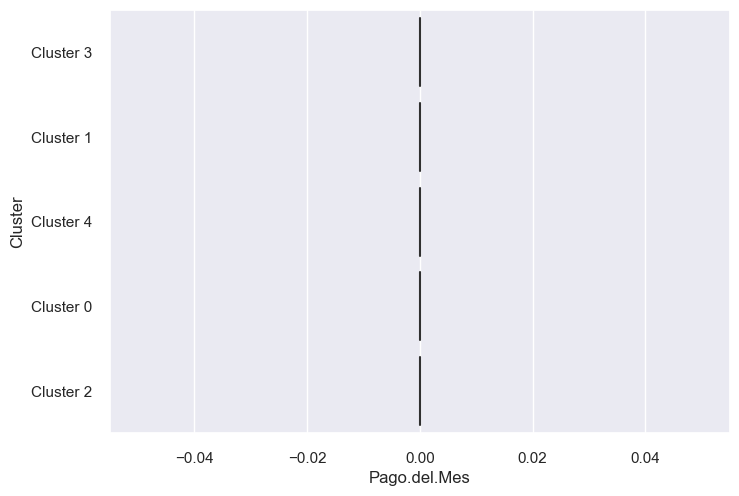

Vr.Mora
IQR:  429792.09375


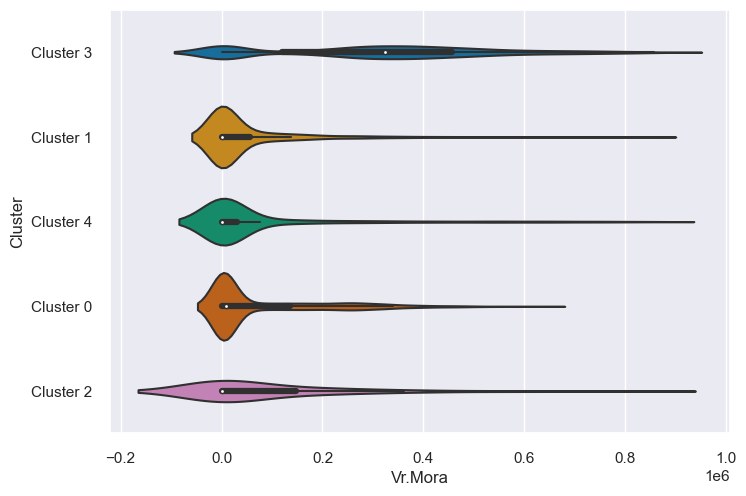

In [203]:
metricas_interes_1 =['Disponible.Avances', 'Limite.Avances', 'Total.Intereses', 'Saldos.Mes.Ant', 'Pagos.Mes.Ant' , 'Limite.Cupo', 'Pago.Minimo', 'Vr.Cuota.Manejo', 'Saldo', 'edad']
metricas_interes_2 =['Vtas.Mes.Ant', 'Edad.Mora', 'Pago.del.Mes', 'Vr.Mora']

for i in metricas_interes_1:
    print(i)
    Q1 = np.percentile(result[i], 25, method='midpoint')
    Q3 = np.percentile(result[i], 75, method='midpoint')
    IQR = Q3 - Q1
    print('IQR: ', 1.5*IQR)
    interes = result[result[i]<=3*IQR]
    sns.set_theme(style="darkgrid")
    sns.set_palette("colorblind")
    sns.violinplot(x=interes[i], orient = 'h', y=interes['Cluster'])
    plt.show()


for i in metricas_interes_2:
    print(i)
    interes = result.copy()
    interes = interes[interes['Edad.Mora']!= 0] 
    Q1 = np.percentile(interes[i], 25, method='midpoint')
    Q3 = np.percentile(interes[i], 75, method='midpoint')
    IQR = Q3 - Q1
    print('IQR: ', 1.5*IQR)
    interes['Edad.Mora'].unique()
    interes = interes[interes[i]<=3*IQR]
    sns.set_theme(style="darkgrid")
    sns.set_palette("colorblind")
    sns.violinplot(x=interes[i], orient = 'h', y=interes['Cluster'])
    plt.show()

Cluster 0    24403
Cluster 1    16690
Cluster 4     5079
Cluster 3     2716
Cluster 2     1113
Name: Cluster, dtype: int64


<Axes: xlabel='Cluster', ylabel='count'>

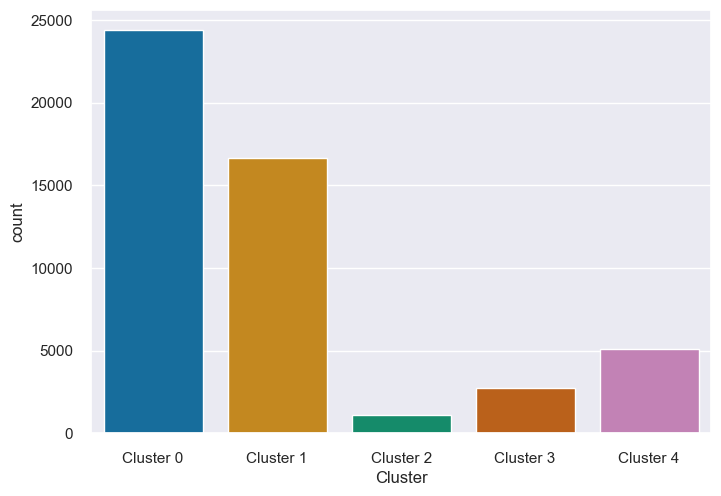

In [228]:
print(result['Cluster'].value_counts())
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")
sns.countplot(x = result['Cluster'], order = np.sort(result.Cluster.unique()))

Conclusiones sobre los segmentos:

El segmento 0 (48%), o segmento Silver se caracteriza por ser el grupo mayoritario, son personas donde sus estudios son de primaria, tienen un mayor numero de personas a cargo y acuden a los subsidios de Lonchera y cuota monetaria

El segmento 1 (34%), o segmento Black se caracteriza por: ser un grupo de personas con estudios técnicos, no tienen subsidio de bono loncheta, pero si cuentan con los mayores cupos y limites de avance dsponibles 

El segmento 2 (3% ), o segmento se caracteriza por: ser personas con niveles academicos superiores (tecnico, universitario o postgrado), tienen máximo 1 persona a cargo, y tienen mayores cupos que los demas segmentos

El segmento 3 (5%) se caracteriza por: Son quienes tienen un mayor numero de personas a cargo, acceden en su mayoria a subsidios como el bono lonchera, son quienes tienen mayores días de mora, mayores deudas y por ende mayores cuotas minimas en sus cupios de crédito

El segmento 4 (10%)se caracteriza por: Personas de un segmento medio, con hasta 2 personas a cargo, suelen acceder a subsidios como el bono de lonchera o cuota monetaria, y tienen cupos de crédito superiores


Teniendo en cuenta lo anterior, la estrategia de campañas de mercadeo debería estar priorizando de la siguiente manera los clientes:
1) Platino, un segmento con buenos cupos como para ofrecerles tarjetas amparadas
2) Black, Un segmento con buenos cupos, y voluminoso, son el segundo segmento más grande
3) Gold, Un segmento con buenos cupos, y con acceso a los subsidios, lo cual simboliza un gran engagement con Colsubsidio
4) Silver: Un segmento con cupos pequeños pero responsables, no destacan por ser morosos
5) Tradicional, un segmento con altas responsabilidades, pero malas conductas de crédito

Donde se debe tener especial precaución con los del segmento tradicional ya que son quienes tienenen conductas de cara al crédito menos sanas 

### <font color='orange'>**e2) Despliegue modelo de segmentación**</font>

En este último paso construiremos los archivos que comprimen nuestros mejores modelos (.pkl), que a su vez son los que podriamos utilizar en el momento de disponibilizar un API bien sea en Docker o en una Máquina virtual (EC2) para que posteriormente pueda seguir siendo consumido, así mismo probaremos su desempeño con la data de test

In [204]:
save_model(kmeans, 'kmeans_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\camil\AppData\Local\Temp\joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['Fecha.Expedicion'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Disponible.Avances',
                                              'Limite.Avances',
                                              'Total....
                  TransformerWrapper(exclude=[], include=None,
                                     transformer=PCA(copy=True,
                                                     iterated_power='auto',
                                    

In [205]:
loaded_model = load_model('kmeans_pipeline')

Transformation Pipeline and Model Successfully Loaded


In [206]:

predictions = predict_model(loaded_model, data = df_test_consolidado)
predictions

,Fecha.Expedicion,Disponible.Avances,Limite.Avances,Total.Intereses,Saldos.Mes.Ant,Pagos.Mes.Ant,Vtas.Mes.Ant,Edad.Mora,Limite.Cupo,Pago.del.Mes,...,estado_civil,Genero,PAC,contrato,estrato,cuota_monetaria,sub_vivenda,bono_lonchera,porc_avances,Cluster
0,2007-06-14,150000.0,150000.0,0.0,0.000000,0.0,0.0,0.0,500000.0,0.0,...,viudo,F,3,1,NaN,1,0,1,0.3,Cluster 0
1,2007-09-18,150000.0,150000.0,0.0,0.000000,0.0,0.0,0.0,500000.0,0.0,...,soltero,F,3,3,NaN,1,0,1,0.3,Cluster 0
2,2007-04-12,540000.0,540000.0,0.0,0.000000,0.0,0.0,0.0,1350000.0,0.0,...,viudo,M,1,1,NaN,0,0,0,0.4,Cluster 1
3,2006-11-17,252000.0,252000.0,0.0,0.000000,0.0,0.0,0.0,840000.0,0.0,...,viudo,F,2,2,NaN,1,0,1,0.3,Cluster 4
4,2007-01-31,760000.0,760000.0,0.0,0.000000,0.0,0.0,0.0,1900000.0,0.0,...,soltero,M,1,4,NaN,0,0,0,0.4,Cluster 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,2018-03-27,45000.0,45000.0,0.0,0.000000,0.0,0.0,0.0,150000.0,0.0,...,viudo,M,3,4,NaN,1,0,1,0.3,Cluster 0
4997,2008-06-06,45000.0,45000.0,0.0,13686.969727,0.0,0.0,0.0,150000.0,0.0,...,soltero,M,3,2,NaN,1,0,1,0.3,Cluster 0
4998,2016-10-03,45000.0,45000.0,0.0,0.000000,0.0,0.0,0.0,150000.0,0.0,...,soltero,M,3,1,NaN,1,0,1,0.3,Cluster 0
4999,2016-10-03,45000.0,45000.0,0.0,2678.510010,15000.0,0.0,0.0,150000.0,0.0,...,separado,M,3,4,NaN,1,0,1,0.3,Cluster 0


### <font color='skyblue'>***Consideraciones Finales***</font>

1) Modelo de Cancelacion, Luego del despliegue es importante tener en cuenta que se recomienda con una periodicidad mensual validar el desempeño del modelo, donde se busque que su AUC se mantenga a lo largo del tiempo, y así mismo validar semestralmente la necesidad de recalibrar o reconstruir el modelo. Así mismo es importante que luego del despliegue del modelo con las estrategias de upselling/cross selling no se esté generando un efecto contrario al que deseamos, donde en lugar de retener a nuestros clientes, estos ante el estímulo que les estemos dando se estén retirando. Por lo cual se recomienda desplegar estas estrategias con un A/B Testing donde se pueda tener un monitoreo constante de lo que sucede con la tasa de churn de clientes dado que recibieron alguna campaña vs la tasa de churn de clientes que no han recibido ningún estimulo (debiendola recibir-grupo control)

2) Modelo de Segmentación: Como se mencionó inicialmente, las conclusiones de los segmentos nacen de los clientes que TIENEN o han tenido crédito, pero se podría evolucionar el ejercicio hacia la construcción de un modelo de clasificación que permita tener un score que resuma la probabilidad de que un cliente nos diga que SI a nuestra oferta de crédito

# **PARTE 2 (15%)**

a) Con los siguientes datos, realiza un análisis de correlación y de regresión (Realizar pregunta para prueba de hipótesis)

* Obtener descriptivos: media, mediana, asimetría
* Realizar pruebas de normalidad (plantear la hipótesis de normalidad)
* (Contestar a la pregunta realizada con base en los resultados de las pruebas)

In [239]:
import scipy
x = pd.Series([2,1,20,21,33,35,37,36,39,38,32,28,27,36,35,34,37,38,39,37,38,39,55,52,35])

y = pd.Series([0,0,25000,26000,30000,18000,18000,18000,15000,15000,29000,28000,26000,17000,16000,18000,19000,16000,14000,19000,14000,13000,55000,48000,15000])


Media y mediana

In [240]:

x.describe()

count    25.000000
mean     32.960000
std      12.019013
min       1.000000
25%      32.000000
50%      36.000000
75%      38.000000
max      55.000000
dtype: float64

In [235]:
y.describe()

count       25.000000
mean     20480.000000
std      11902.800791
min          0.000000
25%      15000.000000
50%      18000.000000
75%      26000.000000
max      55000.000000
dtype: float64

Asimetria - Skewness

In [242]:
scipy.stats.skew(x, axis=0, bias=True) # Sesgo negativo (Cola izquierda)

-1.1660991574981163

In [238]:
scipy.stats.skew(y, axis=0, bias=True) # Sesgo positivo (Cola derecha)

1.1445534202079868

Test de Normalidad

H0: Normalmente distribuida 

H1: No es normalmente distribuida


In [244]:

from scipy.stats import kstest
kstest(x, 'norm')
# Con una significacia del 5%, podemos rechazar la hipotesis nula ya que el pvalue es inferior, por lo cual podemos decir que la función no está normalmente distribuida


KstestResult(statistic=0.9372498680518208, pvalue=1.7433961565089196e-30, statistic_location=2, statistic_sign=-1)

In [246]:
kstest(y, 'norm')
# Con una significacia del 5%, podemos rechazar la hipotesis nula ya que el pvalue es inferior, por lo cual podemos decir que la función no está normalmente distribuida


KstestResult(statistic=0.92, pvalue=7.55591585108062e-28, statistic_location=13000, statistic_sign=-1)

Correlacion y regresión

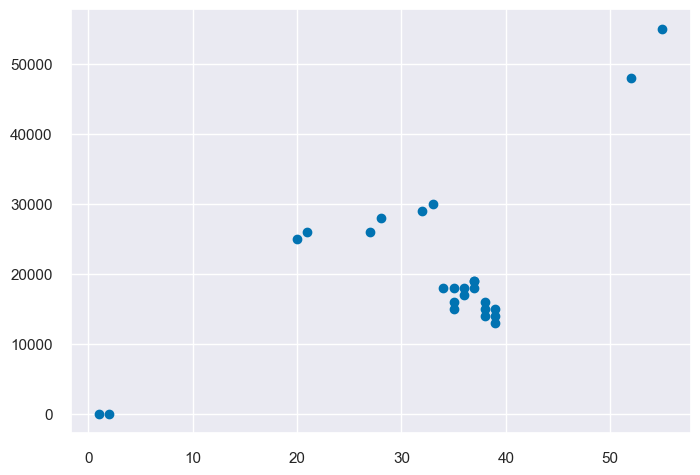

In [252]:
plt.scatter(x,y)
plt.show()

In [255]:
from scipy.stats import pearsonr
corr, _ = pearsonr(x, y)
print('Pearsons correlation: %.3f' % corr)
#Tenemos una correlación positiva pero no muy fuerte entre las dos variables del 61.2%

Pearsons correlation: 0.612


In [256]:
import statsmodels.api as sm
mod = sm.OLS(x, y)
res = mod.fit()
print(res.summary())
# Tenemos un R2 del 84.7% lo cual resprestenta el % de la variabilidad de Y explicada con X, un coeficiente positivo del 0.0014 (significativo) el cual nos indica que por cada unidad que crezca X, Y lo hará en 0.0014

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.847
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              132.8
Date:                Sun, 14 May 2023   Prob (F-statistic):                    2.88e-11
Time:                        19:31:26   Log-Likelihood:                         -100.90
No. Observations:                  25   AIC:                                      203.8
Df Residuals:                      24   BIC:                                      205.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# **PARTE 3 (10%)**

a) ¿cuál es su interpretación de la siguiente matriz? (argumente su respuesta)

<img src="https://github.com/juankfc/DataScientist-Roadmap/blob/main/Col%20Assessment/Matrix.png?raw=true"/>


Es una matriz de confusión diseñada  como resultado de la construcción de un modelo predictivo donde cuya variable Dependiente tiene 8 posibles opciones.

A groso modo podemos obtener conclusiones como:
El modelo es muy poderoso para identificar cuando Y = 2, el 100% de las observaciones fueron bien clasificadas
Carece de poder predictivo cuando Y = 5, tiene tan solo una Sensitividad del 36% en esta clase (80/2022)


b)¿Cuáles y cuántas métricas puede obtener de dicha matriz? (argumente su respuesta)

Al ser una matriz de confusión de un modelo de clasificación multiclass, podemos calcular para cada una de las 8 respuestas de forma independiente las métricas de Accuracy, Precision, Recall(Sensitividad), Especificidad, AUC y si lo deseamos F1 score, es decir 48 métricas diferentes.

Y para tener una vista general de la matriz completa podríamos tener 6 adicionales calculando el promedio por ejemplo de todos los “RECALL", y un Accuracy general basado en la diagonal de la matriz, es decir un total de 55 métricas distintas



